In [ ]:
import pandas as pd
import numpy as np
import math
from scipy import signal
from statsmodels.nonparametric.smoothers_lowess import lowess
from numpy import array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

In [4]:
def split_sequences(sequences, n_steps):
    inputnn, target = list(), list()
    for i in range(len(sequences)):
        end_ix = i + n_steps
        if end_ix + 1 > len(sequences):
            break
        seq_x, seq_y = sequences[i:end_ix], sequences[end_ix, (1, 4, 7)]
        inputnn.append(seq_x)
        target.append(seq_y)
    return array(inputnn), array(target)

In [5]:
data = pd.read_csv("D:\drive\GitHub\Weather-Forecasting-CBR-fox\Jupyter\weatherdata.csv", parse_dates=True, index_col=1)

In [141]:
data

,DATE,TEMP_MAX,TEMP_MIN,TEMP_AVG,PRES_AVG,PRES_MAX,PRES_MIN,HUM_AVG,HUM_MAX,HUM_MIN
MONTH,,,,,,,,,,
JANUARY,2000-01-01,29.9,19.2,24.55,23.100000,25.300000,18.500000,80.000000,96.000000,55.000000
JANUARY,2000-01-02,31.6,21.0,26.30,24.900000,27.600000,23.200000,78.000000,93.000000,53.000000
JANUARY,2000-01-03,31.2,20.0,25.60,25.000000,29.300000,23.300000,83.000000,99.000000,54.000000
JANUARY,2000-01-04,30.8,18.8,24.80,24.500000,27.100000,22.800000,87.000000,99.000000,55.000000
JANUARY,2000-01-05,23.8,18.8,21.30,21.300000,23.200000,19.200000,87.000000,96.000000,72.000000
...,...,...,...,...,...,...,...,...,...,...
SEPTEMBER,2018-09-25,35.2,24.6,29.90,33.605244,39.293133,29.971286,85.807829,96.598891,66.220121
SEPTEMBER,2018-09-26,35.7,24.8,30.25,33.215072,38.461184,30.121252,84.474650,95.796130,65.107947
SEPTEMBER,2018-09-27,34.5,24.7,29.60,33.329421,39.033815,30.356106,87.932543,98.304236,71.282447


In [149]:
step_days = 14
dataset = data.filter(['HUM_MIN', 'HUM_AVG', 'HUM_MAX', 'PRES_MIN', 'PRES_AVG', 'PRES_MAX', 'TEMP_MIN',
                       'TEMP_AVG', 'TEMP_MAX']).values
dataset = np.array(dataset)
# dataset = MinMaxScaler().fit_transform(dataset)
global inputnn, target, input_train, input_test, target_test, target_train
inputnn, target = split_sequences(dataset, step_days)
input_train, input_test, target_train, target_test = train_test_split(inputnn, target, test_size=0.30,
                                                                      random_state=4, shuffle=False)

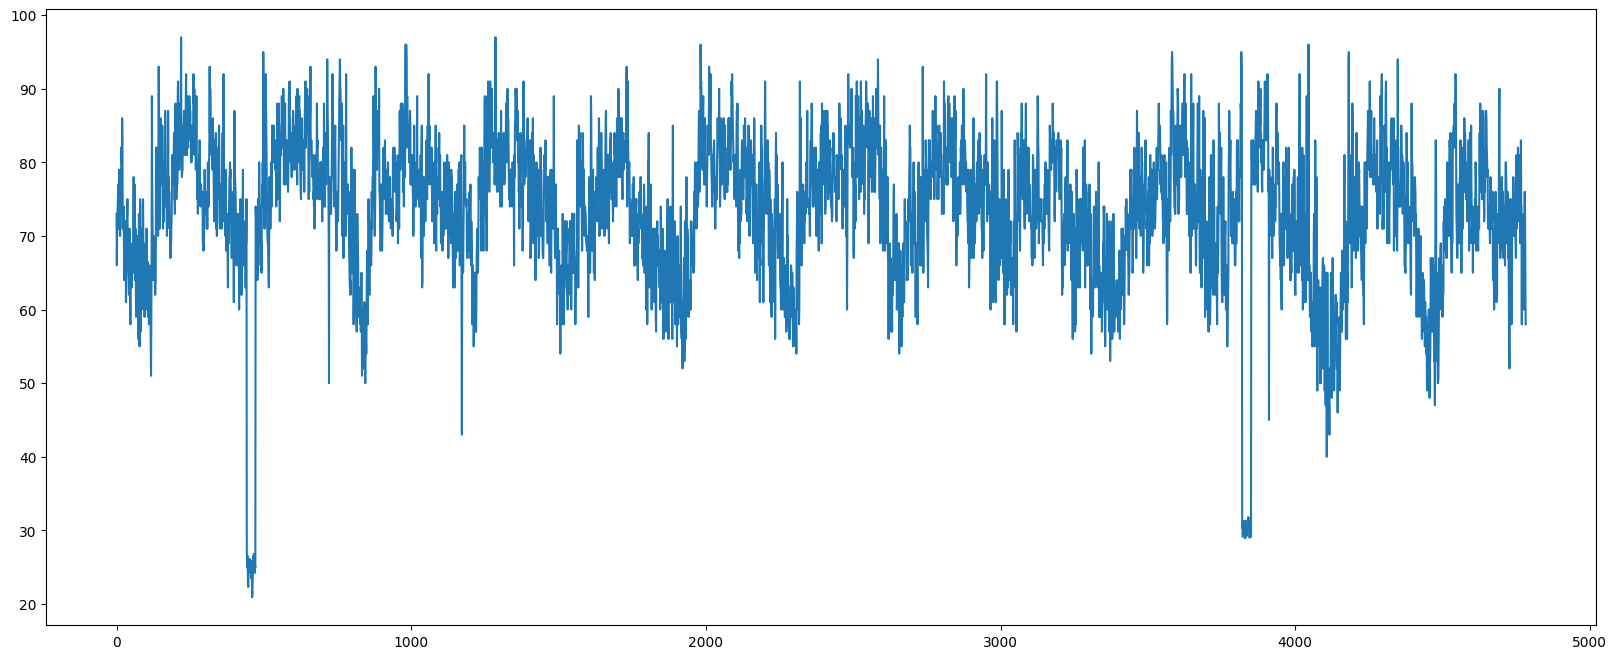

In [150]:
plt.figure(figsize=(20, 8))
plt.plot(target_train[:, 0])

In [8]:
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(step_days, input_train.shape[2])))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(3))
model.compile(optimizer='adam', loss='mse')
history = model.fit(input_train, target_train, validation_data=(input_test, target_test), batch_size=16, epochs=10)

Epoch 1/10
299/299 [==============================] - 13s 26ms/step - loss: 386.4691 - val_loss: 49.6242
Epoch 2/10
299/299 [==============================] - 6s 21ms/step - loss: 181.0794 - val_loss: 54.1520
Epoch 3/10
299/299 [==============================] - 6s 20ms/step - loss: 153.3985 - val_loss: 30.5490
Epoch 4/10
299/299 [==============================] - 7s 22ms/step - loss: 133.0209 - val_loss: 90.5412
Epoch 5/10
299/299 [==============================] - 6s 21ms/step - loss: 127.4850 - val_loss: 25.5286
Epoch 6/10
299/299 [==============================] - 6s 19ms/step - loss: 124.4140 - val_loss: 27.8418
Epoch 7/10
299/299 [==============================] - 6s 19ms/step - loss: 116.5868 - val_loss: 25.3454
Epoch 8/10
299/299 [==============================] - 6s 20ms/step - loss: 115.3781 - val_loss: 23.3094
Epoch 9/10
299/299 [==============================] - 7s 23ms/step - loss: 117.1175 - val_loss: 55.6047
Epoch 10/10
299/299 [==============================] - 6s 19ms/

In [9]:
prediction_train = model.predict(input_train)
RMSE = math.sqrt(np.square(np.subtract(prediction_train, target_train)).mean())
print("Root Mean Square Error Train:\n", RMSE)
prediction = model.predict(input_test)
RMSE = math.sqrt(np.square(np.subtract(prediction, target_test)).mean())
print("Root Mean Square Error Test:\n", RMSE)

150/150 [==============================] - 2s 9ms/step
Root Mean Square Error Train:
 4.782259470814549
65/65 [==============================] - 1s 8ms/step
Root Mean Square Error Test:
 4.54791044246516


In [299]:
prediction = model.predict(inputnn[-1].reshape((1, 14, 9)))

1/1 [==============================] - 0s 226ms/step


In [279]:
windows = inputnn[0:-1]
targetWindow = inputnn[-1]
num_cases = 5
target = target
smoothnessFactor = .04
inputNames = ['HUM_MIN', 'HUM_AVG', 'HUM_MAX', 'PRES_MIN', 'PRES_AVG', 'PRES_MAX', 'TEMP_MIN',
              'TEMP_AVG', 'TEMP_MAX']
outputNames = ['HUM_AVG', 'PRES_AVG', 'TEMP_AVG']
titleColumns = ["Humidity", "Vapor Pressure", "Temperature"]
punishedSumFactor = .5

componentsLen = windows.shape[2]
windowLen = windows.shape[1]
windowsLen = len(windows)
predictionTargetWindow = prediction
# predictionTargetWindow = modelo.predict(targetWindow.reshape((1,windowLen, componentsLen)))

1/1 [==============================] - 0s 43ms/step


In [280]:
predictionTargetWindow

array([[82.0984  , 28.407907, 30.538937]], dtype=float32)

In [193]:
pearsonCorrelation = np.array(
    ([np.corrcoef(windows[currentWindow, :, currentComponent], targetWindow[:, currentComponent])[0][1]
      for currentWindow in range(len(windows)) for currentComponent in range(componentsLen)])).reshape(-1,
                                                                                                       componentsLen)
euclideanDistance = np.array(
    ([np.linalg.norm(targetWindow[:, currentComponent] - windows[currentWindow, :, currentComponent])
      for currentWindow in range(windowsLen) for currentComponent in range(componentsLen)])).reshape(-1,
                                                                                                     componentsLen)

D:\programas\Python310\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
D:\programas\Python310\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [194]:
pearsonCorrelation

array([[ 0.27666848,  0.46535762,  0.08558042, ..., -0.27791801,
         0.07758785,  0.01786163],
       [ 0.12295542,  0.25779803,  0.29202388, ...,  0.23494243,
         0.27865699,  0.46122777],
       [ 0.24236243,  0.28905067,  0.25801899, ...,  0.11713041,
        -0.03801745,  0.08427468],
       ...,
       [ 0.24747329,  0.08584955, -0.68139021, ..., -0.38272937,
        -0.04340675, -0.05068311],
       [ 0.01094916, -0.1788472 , -0.17899986, ..., -0.01272789,
        -0.38239545, -0.08469566],
       [-0.43413295, -0.19586851,  0.41862268, ...,  0.27713364,
         0.16699404,  0.00203411]])

In [195]:
normalizedEuclideanDistance = euclideanDistance / np.amax(euclideanDistance, axis=0)

In [196]:
normalizedEuclideanDistance

array([[0.31478206, 0.12275821, 0.15300827, ..., 0.43734187, 0.48936571,
        0.49482786],
       [0.32980824, 0.13799735, 0.17103242, ..., 0.43606929, 0.48960006,
        0.47959135],
       [0.33953211, 0.15696462, 0.18116514, ..., 0.46384488, 0.52160141,
        0.51482693],
       ...,
       [0.16705023, 0.08342388, 0.17833882, ..., 0.11029456, 0.07620383,
        0.11019163],
       [0.19105432, 0.09558715, 0.15257774, ..., 0.09612593, 0.09060185,
        0.11345234],
       [0.22994978, 0.09585737, 0.1069274 , ..., 0.08219486, 0.07046025,
        0.1092884 ]])

In [197]:
normalizedCorrelation = (.5 + (pearsonCorrelation - 2 * normalizedEuclideanDistance + 1) / 4)

In [198]:
normalizedCorrelation

array([[0.66177609, 0.8049603 , 0.69489097, ..., 0.46184956, 0.52471411,
        0.50705148],
       [0.61583473, 0.74545083, 0.73748976, ..., 0.59070096, 0.57486422,
        0.62551127],
       [0.64082455, 0.74378036, 0.72392218, ..., 0.54736016, 0.47969493,
        0.51365521],
       ...,
       [0.72834321, 0.72975045, 0.49048304, ..., 0.59917038, 0.7010464 ,
        0.68223341],
       [0.65721013, 0.65749463, 0.62896116, ..., 0.69875506, 0.60910021,
        0.67209991],
       [0.52649187, 0.65310419, 0.80119197, ..., 0.77818598, 0.75651838,
        0.69586433]])

In [199]:
correlationPerWindow = np.sum(((normalizedCorrelation + punishedSumFactor) ** 2), axis=1)

In [200]:
correlationPerWindow

array([ 9.89112723, 10.59925813, 10.03237818, ..., 12.21712459,
       12.6849959 , 13.90903998])

In [201]:
correlationPerWindow /= max(correlationPerWindow)

In [202]:
correlationPerWindow

array([0.65798468, 0.70509147, 0.66738108, ..., 0.81271635, 0.84384042,
       0.92526716])

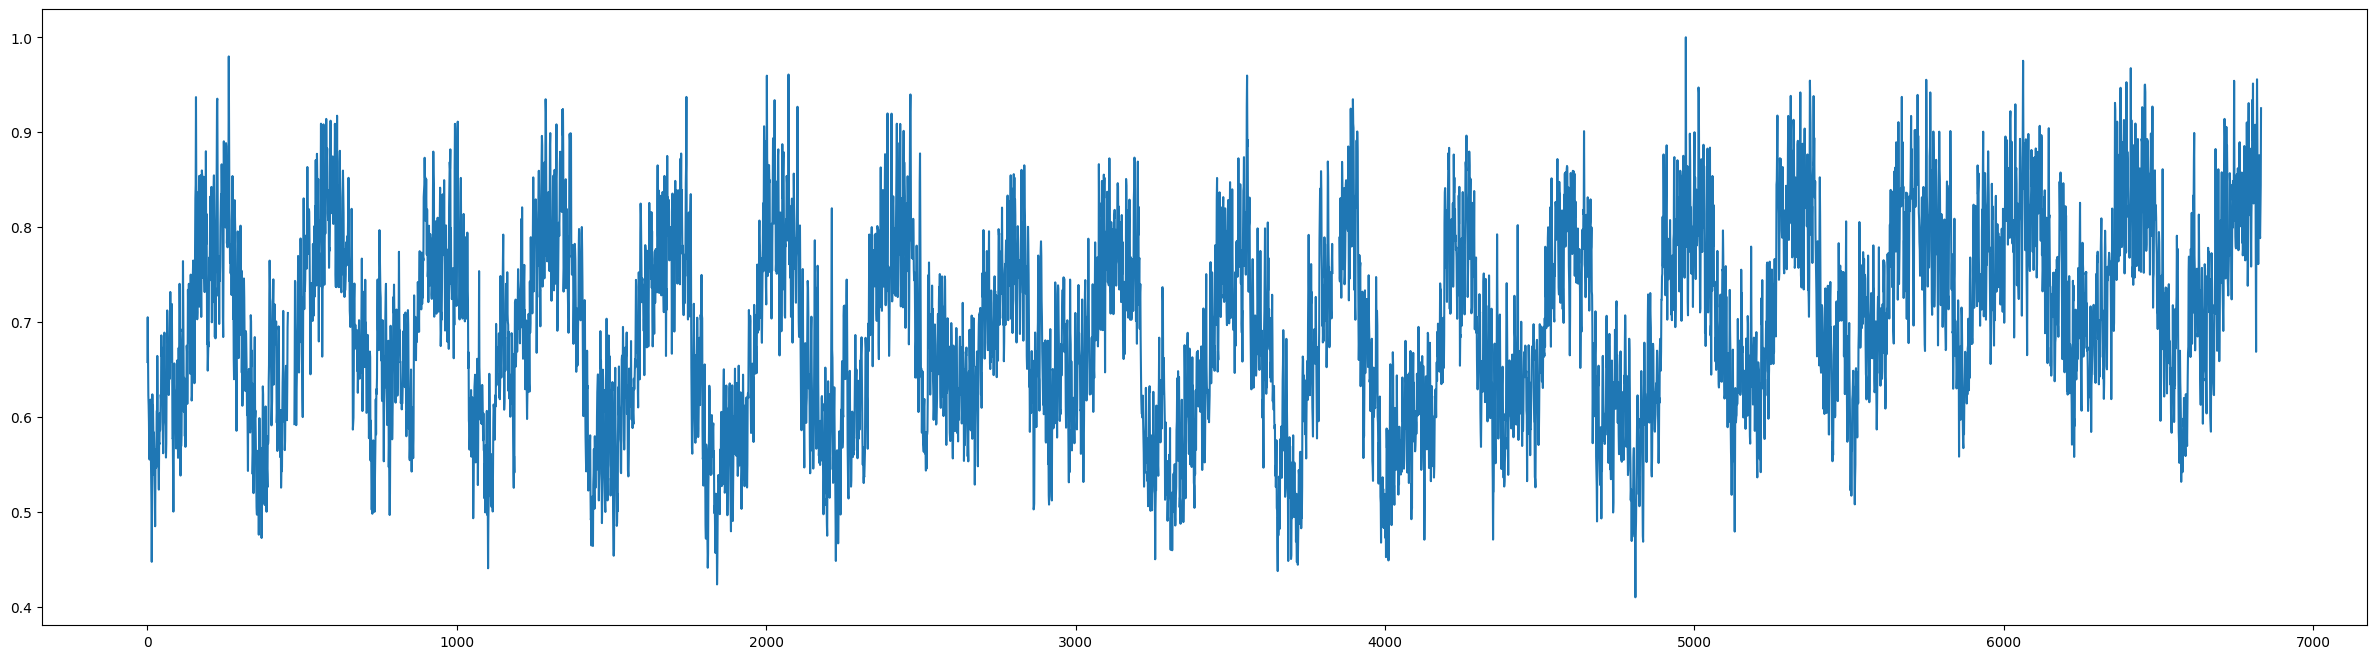

In [203]:
plt.figure(figsize=(30, 8))
plt.plot(correlationPerWindow)

In [204]:
smoothedCorrelation = lowess(correlationPerWindow, np.arange(len(correlationPerWindow)), smoothnessFactor)[:, 1]

In [205]:
smoothedCorrelation

array([0.55907873, 0.56004916, 0.56102032, ..., 0.86814584, 0.86895071,
       0.86975489])

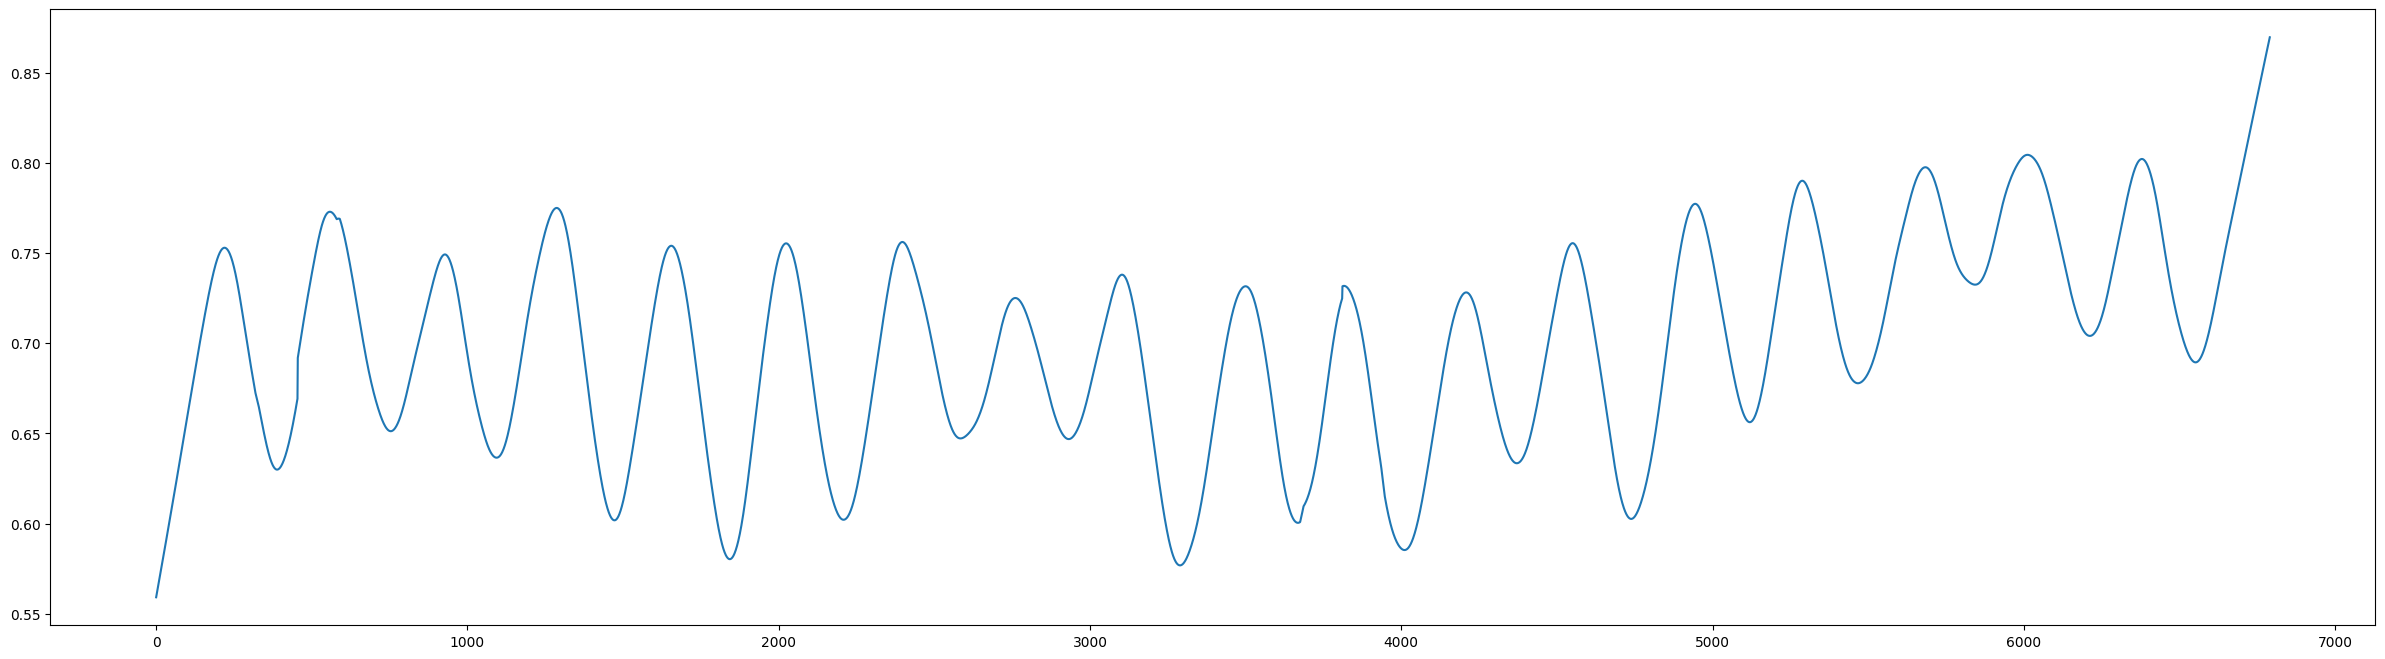

In [206]:
plt.figure(figsize=(30, 8))
plt.plot(smoothedCorrelation)

In [207]:
valleyIndex, peakIndex = signal.argrelextrema(smoothedCorrelation, np.less)[0], \
    signal.argrelextrema(smoothedCorrelation, np.greater)[0]

In [208]:
print(valleyIndex)
print(len(valleyIndex))

[ 388  580  754 1094 1472 1843 2208 2584 2932 3289 3668 4010 4371 4739
 5119 5467 5843 6212 6552]
19


In [209]:
print(peakIndex)
print(len(peakIndex))

[ 220  558  586  928 1287 1655 2024 2397 2760 3103 3500 3816 4209 4550
 4944 5288 5684 6012 6379]
19


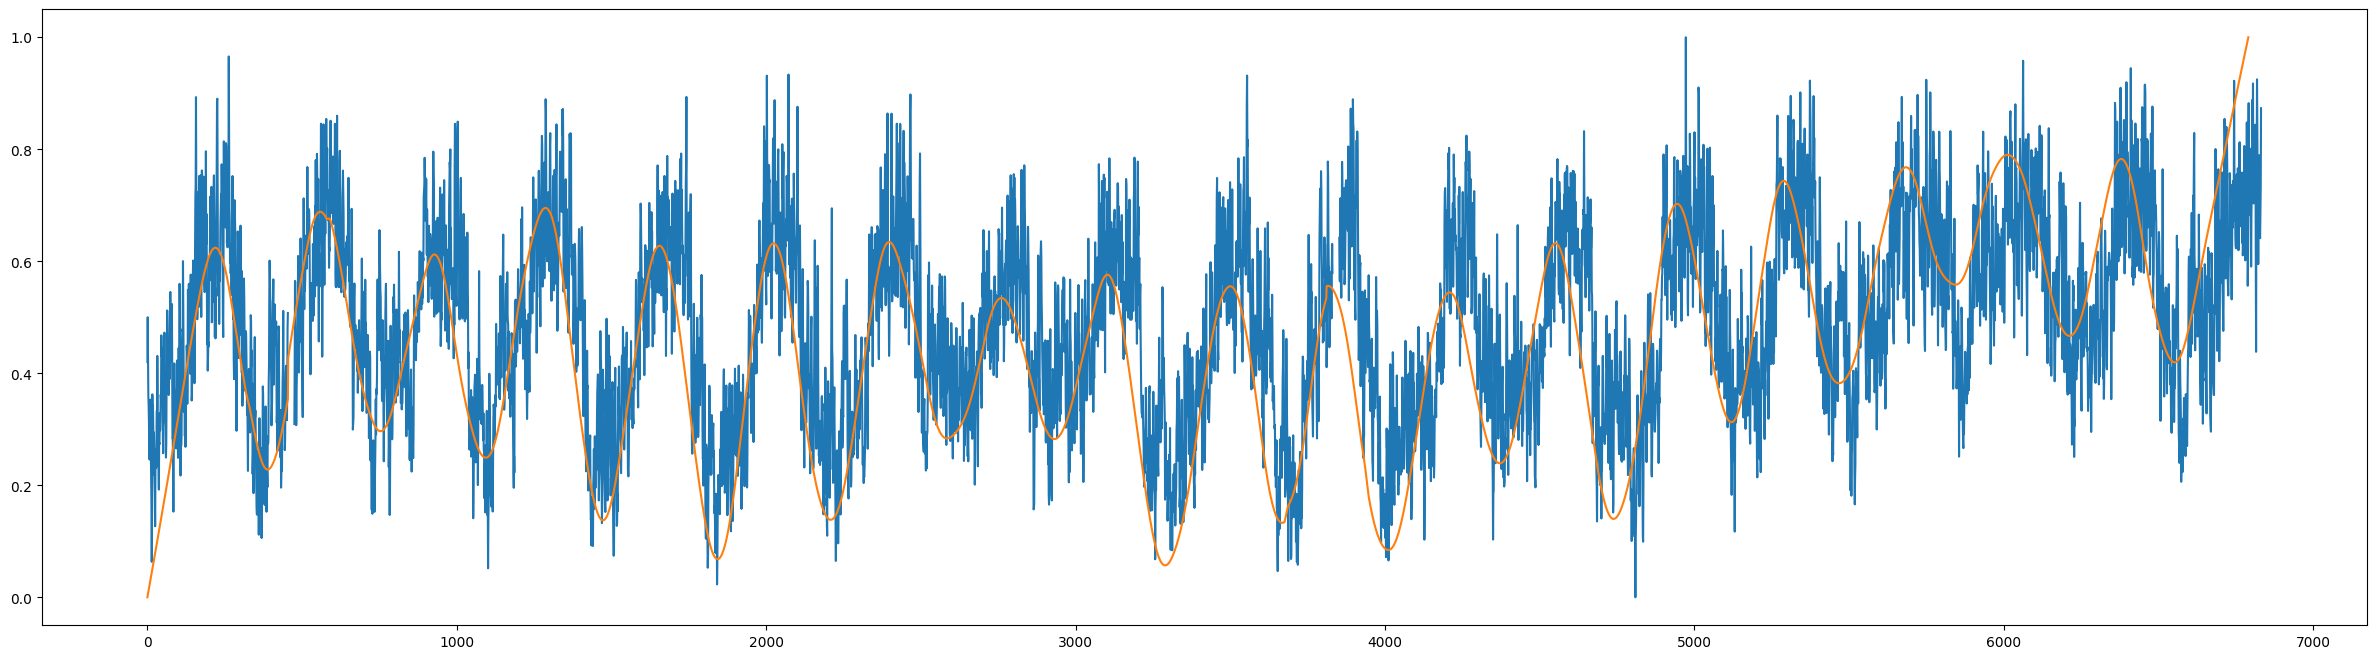

In [210]:
plt.figure(figsize=(30, 8))
plt.plot(range(len(correlationPerWindow)), MinMaxScaler().fit_transform(correlationPerWindow.reshape(-1, 1)))
plt.plot(range(len(smoothedCorrelation)), MinMaxScaler().fit_transform(smoothedCorrelation.reshape(-1, 1)))
# plt.scatter(peakIndex, [smoothedCorrelation2[peak] for peak in peakIndex])
# plt.scatter(valleyIndex, [smoothedCorrelation2[valley] for valley in valleyIndex])

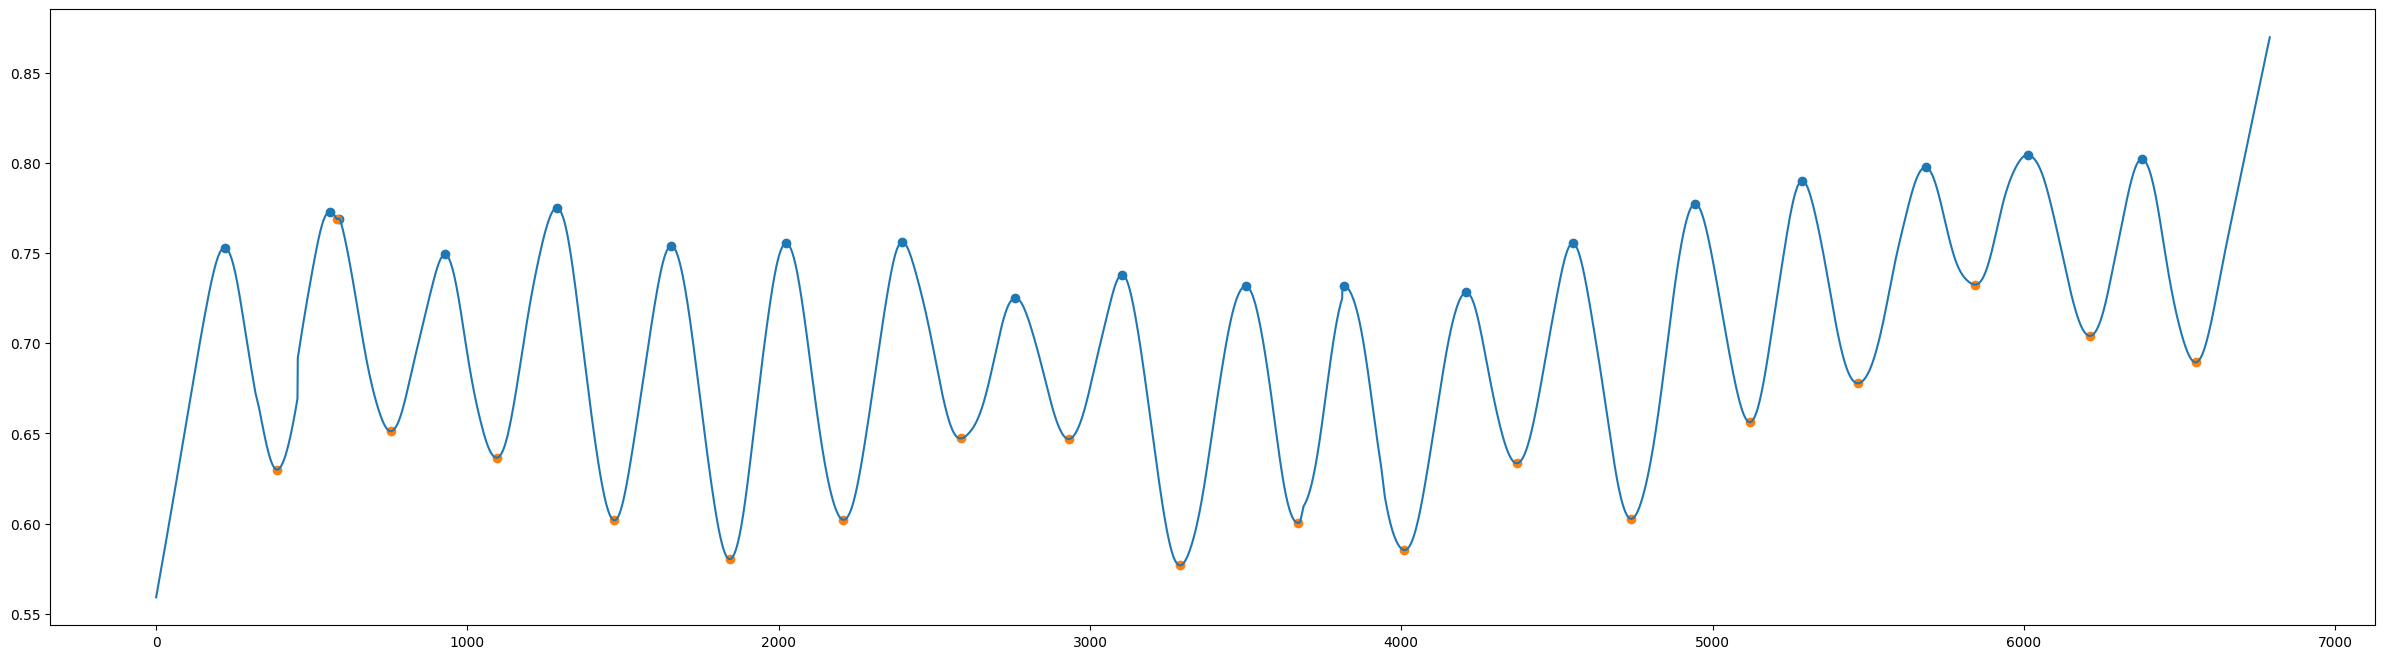

In [211]:
plt.figure(figsize=(30, 8))
plt.plot(smoothedCorrelation)
plt.scatter(peakIndex, [smoothedCorrelation[peak] for peak in peakIndex])
plt.scatter(valleyIndex, [smoothedCorrelation[valley] for valley in valleyIndex])

In [212]:
concaveSegments = np.split(np.transpose(np.array((np.arange(windowsLen), correlationPerWindow))), valleyIndex)

In [213]:
concaveSegments

[array([[  0.        ,   0.65798468],
        [  1.        ,   0.70509147],
        [  2.        ,   0.66738108],
        [  3.        ,   0.62280293],
        [  4.        ,   0.61208669],
        [  5.        ,   0.59462462],
        [  6.        ,   0.55914752],
        [  7.        ,   0.55522012],
        [  8.        ,   0.5793771 ],
        [  9.        ,   0.61063725],
        [ 10.        ,   0.61831306],
        [ 11.        ,   0.56842691],
        [ 12.        ,   0.54061825],
        [ 13.        ,   0.51071287],
        [ 14.        ,   0.44750689],
        [ 15.        ,   0.49713024],
        [ 16.        ,   0.62389694],
        [ 17.        ,   0.59338311],
        [ 18.        ,   0.61245996],
        [ 19.        ,   0.58845594],
        [ 20.        ,   0.5396075 ],
        [ 21.        ,   0.58378659],
        [ 22.        ,   0.5691649 ],
        [ 23.        ,   0.53560507],
        [ 24.        ,   0.51892187],
        [ 25.        ,   0.48496178],
        [ 26

In [214]:
convexSegments = np.split(np.transpose(np.array((np.arange(windowsLen), correlationPerWindow))), peakIndex)

In [215]:
convexSegments

[array([[  0.        ,   0.65798468],
        [  1.        ,   0.70509147],
        [  2.        ,   0.66738108],
        [  3.        ,   0.62280293],
        [  4.        ,   0.61208669],
        [  5.        ,   0.59462462],
        [  6.        ,   0.55914752],
        [  7.        ,   0.55522012],
        [  8.        ,   0.5793771 ],
        [  9.        ,   0.61063725],
        [ 10.        ,   0.61831306],
        [ 11.        ,   0.56842691],
        [ 12.        ,   0.54061825],
        [ 13.        ,   0.51071287],
        [ 14.        ,   0.44750689],
        [ 15.        ,   0.49713024],
        [ 16.        ,   0.62389694],
        [ 17.        ,   0.59338311],
        [ 18.        ,   0.61245996],
        [ 19.        ,   0.58845594],
        [ 20.        ,   0.5396075 ],
        [ 21.        ,   0.58378659],
        [ 22.        ,   0.5691649 ],
        [ 23.        ,   0.53560507],
        [ 24.        ,   0.51892187],
        [ 25.        ,   0.48496178],
        [ 26

In [216]:
bestWindowsIndex, worstWindowsIndex = list(), list()

for split in concaveSegments:
    bestWindowsIndex.append(int(split[np.where(split == max(split[:, 1]))[0][0], 0]))

In [217]:
bestWindowsIndex

[263,
 578,
 613,
 1003,
 1287,
 1742,
 2072,
 2466,
 2834,
 3190,
 3554,
 3896,
 4263,
 4643,
 4972,
 5373,
 5749,
 6062,
 6410,
 6818]

In [218]:
for split in convexSegments:
    worstWindowsIndex.append(int(split[np.where(split == min(split[:, 1]))[0][0], 0]))

In [219]:
worstWindowsIndex

[14,
 369,
 565,
 783,
 1101,
 1507,
 1841,
 2225,
 2674,
 2864,
 3257,
 3653,
 4011,
 4349,
 4809,
 5130,
 5518,
 5855,
 6227,
 6573]

In [220]:
bestDic = {index: correlationPerWindow[index] for index in bestWindowsIndex}

In [221]:
bestDic

{263: 0.9798339163569642,
 578: 0.9140070214771644,
 613: 0.9173728708117267,
 1003: 0.9111344895824043,
 1287: 0.9347267893099894,
 1742: 0.9371730450439352,
 2072: 0.9607701136775556,
 2466: 0.9397756670972366,
 2834: 0.8651545453021197,
 3190: 0.8732349574479349,
 3554: 0.9596691502268719,
 3896: 0.9347294233986332,
 4263: 0.8964210386606888,
 4643: 0.9010981822931746,
 4972: 1.0,
 5373: 0.9543382039201235,
 5749: 0.9552257972433285,
 6062: 0.9752525201439582,
 6410: 0.9674628084385888,
 6818: 0.9557187905117157}

In [222]:
worstDic = {index: correlationPerWindow[index] for index in worstWindowsIndex}

In [223]:
worstDic

{14: 0.44750688713776837,
 369: 0.4725965393579963,
 565: 0.6636231256344319,
 783: 0.49681135048428765,
 1101: 0.4407020137282937,
 1507: 0.4539163171174572,
 1841: 0.4237133866848007,
 2225: 0.4484300015283161,
 2674: 0.5288142255584809,
 2864: 0.5027220383761128,
 3257: 0.4501815252240953,
 3653: 0.43775095060419345,
 4011: 0.44897190399730097,
 4349: 0.470897771979593,
 4809: 0.4101551308293398,
 5130: 0.4793617671108923,
 5518: 0.5080418196903081,
 5855: 0.5582948427534266,
 6227: 0.5579855196759201,
 6573: 0.5317775841711495}

In [224]:
bestSorted = sorted(bestDic.items(), reverse=True, key=lambda x: x[1])

In [225]:
bestSorted

[(4972, 1.0),
 (263, 0.9798339163569642),
 (6062, 0.9752525201439582),
 (6410, 0.9674628084385888),
 (2072, 0.9607701136775556),
 (3554, 0.9596691502268719),
 (6818, 0.9557187905117157),
 (5749, 0.9552257972433285),
 (5373, 0.9543382039201235),
 (2466, 0.9397756670972366),
 (1742, 0.9371730450439352),
 (3896, 0.9347294233986332),
 (1287, 0.9347267893099894),
 (613, 0.9173728708117267),
 (578, 0.9140070214771644),
 (1003, 0.9111344895824043),
 (4643, 0.9010981822931746),
 (4263, 0.8964210386606888),
 (3190, 0.8732349574479349),
 (2834, 0.8651545453021197)]

In [226]:
worstSorted = sorted(worstDic.items(), key=lambda x: x[1])

In [227]:
worstSorted

[(4809, 0.4101551308293398),
 (1841, 0.4237133866848007),
 (3653, 0.43775095060419345),
 (1101, 0.4407020137282937),
 (14, 0.44750688713776837),
 (2225, 0.4484300015283161),
 (4011, 0.44897190399730097),
 (3257, 0.4501815252240953),
 (1507, 0.4539163171174572),
 (4349, 0.470897771979593),
 (369, 0.4725965393579963),
 (5130, 0.4793617671108923),
 (783, 0.49681135048428765),
 (2864, 0.5027220383761128),
 (5518, 0.5080418196903081),
 (2674, 0.5288142255584809),
 (6573, 0.5317775841711495),
 (6227, 0.5579855196759201),
 (5855, 0.5582948427534266),
 (565, 0.6636231256344319)]

In [300]:
bestSorted = bestSorted[0:num_cases]
worstSorted = worstSorted[0:num_cases]

NameError: name 'num_cases' is not defined

In [229]:
bestSorted

[(4972, 1.0),
 (263, 0.9798339163569642),
 (6062, 0.9752525201439582),
 (6410, 0.9674628084385888)]

In [230]:
worstSorted

[(4809, 0.4101551308293398),
 (1841, 0.4237133866848007),
 (3653, 0.43775095060419345),
 (1101, 0.4407020137282937)]

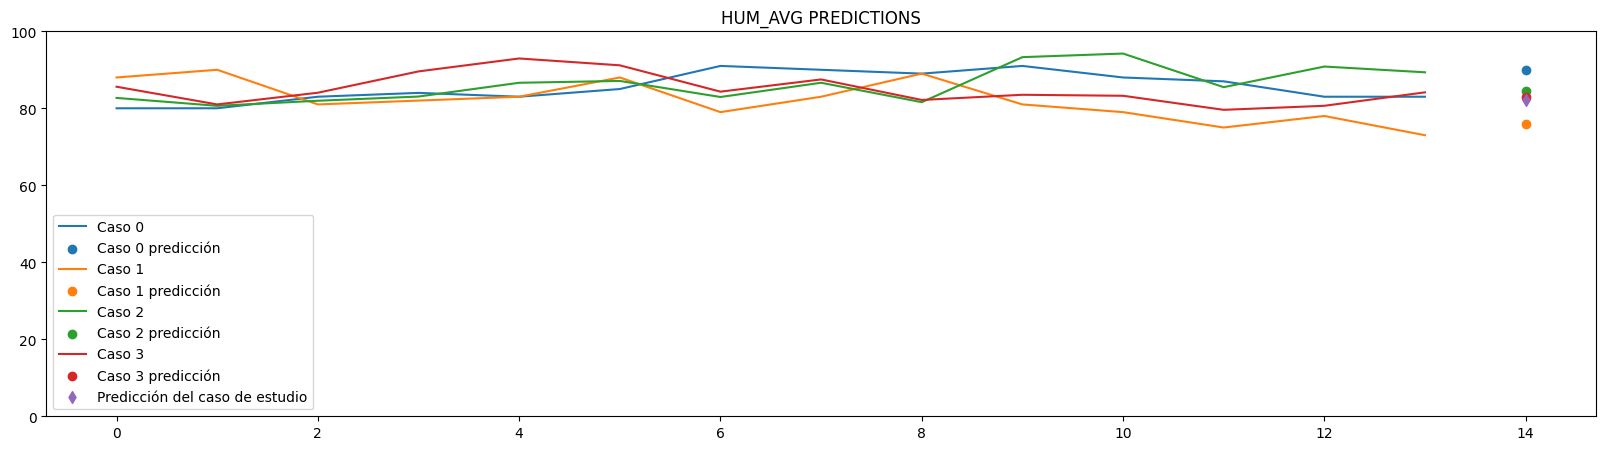

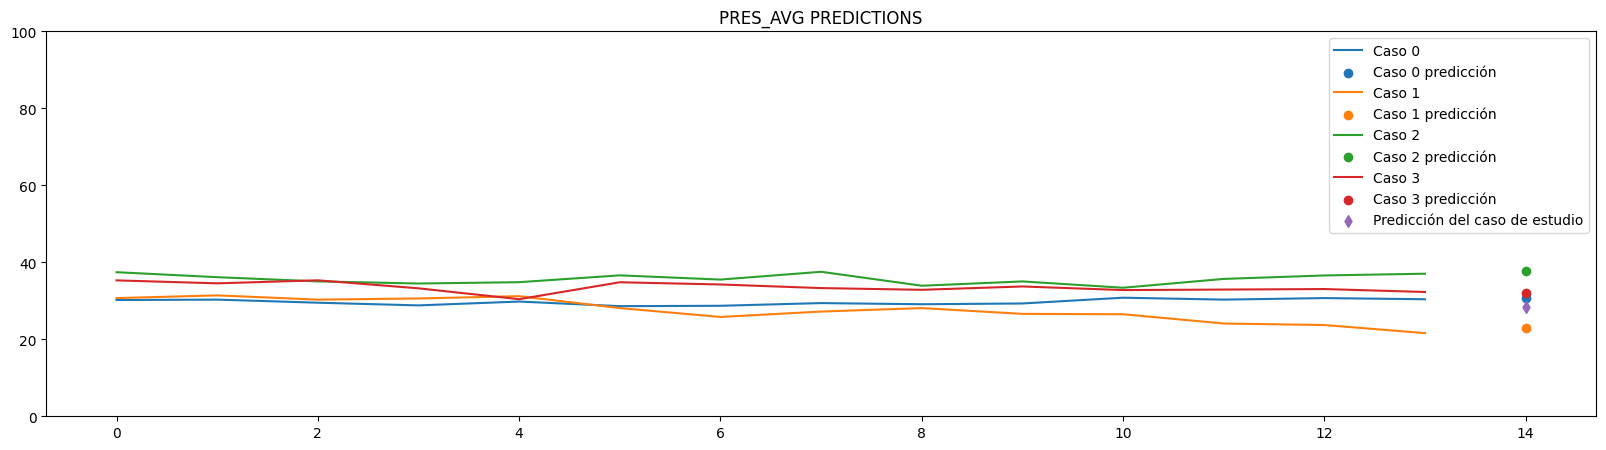

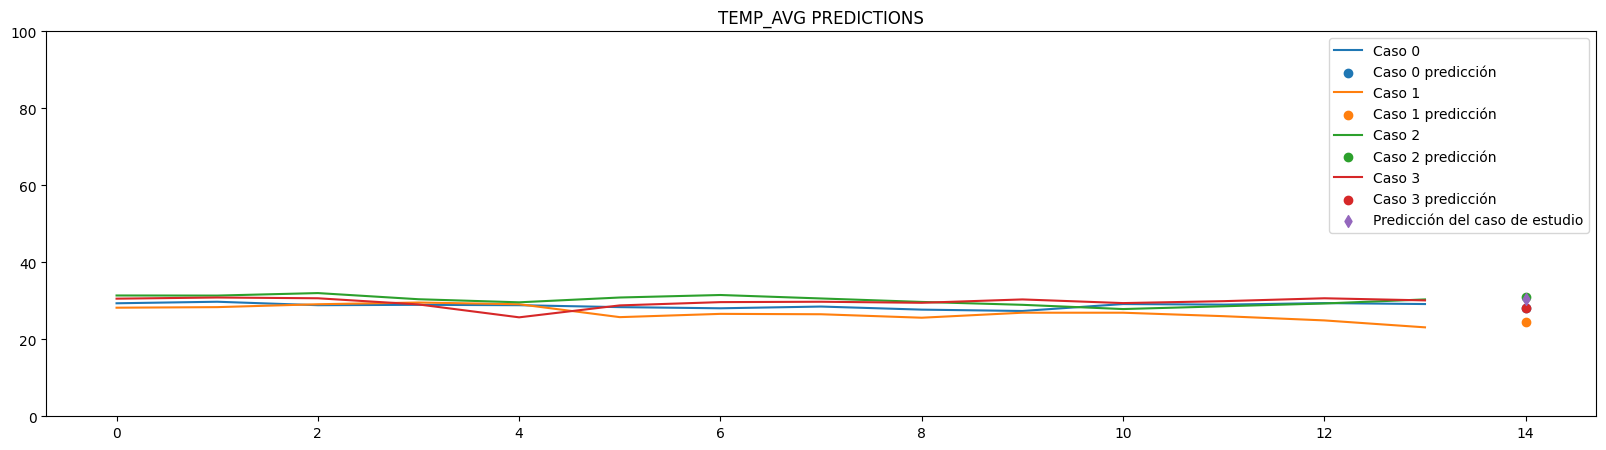

In [297]:
for n_component in range(3):
    plt.figure(figsize=(20, 5))
    plt.title(outputNames[n_component] + " PREDICTIONS")
    plt.ylim((0, 100))
    for i, tupla in enumerate(bestSorted):
        pass
        plt.plot(target[tupla[0]: tupla[0] + windowLen][:, n_component], label="Caso " + str(i))
        plt.scatter(windowLen, target[tupla[0] + windowLen + 1][n_component], label="Caso " + str(i) + " predicción")
    plt.scatter(windowLen, predictionTargetWindow[:, n_component], marker="d", label="Predicción del caso de estudio")
    plt.legend()

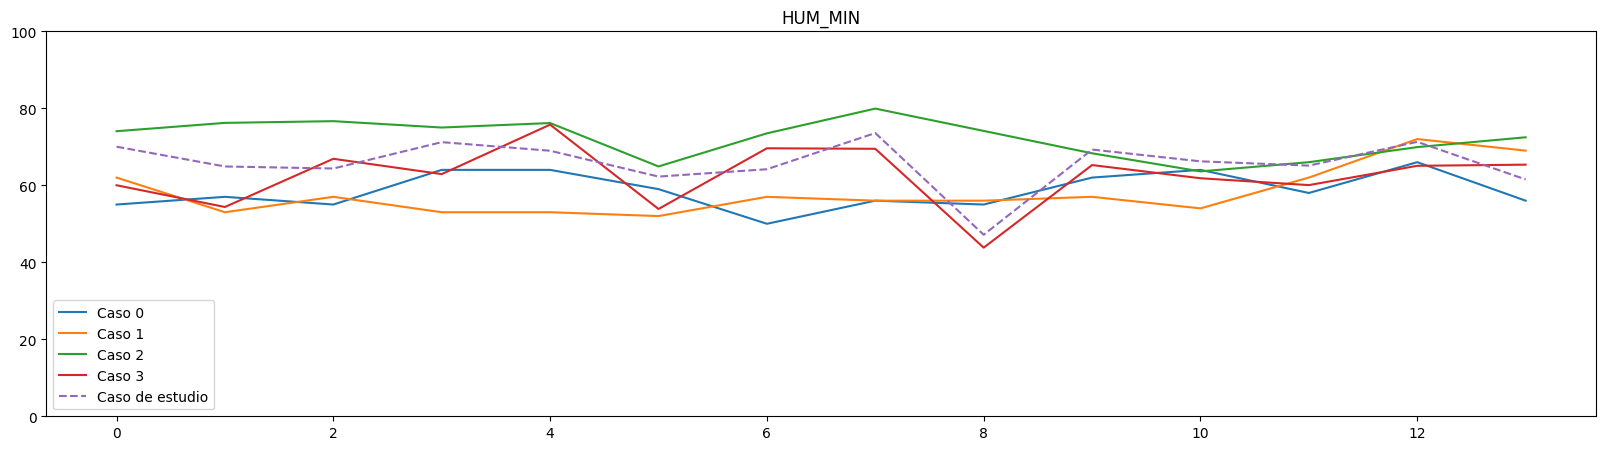

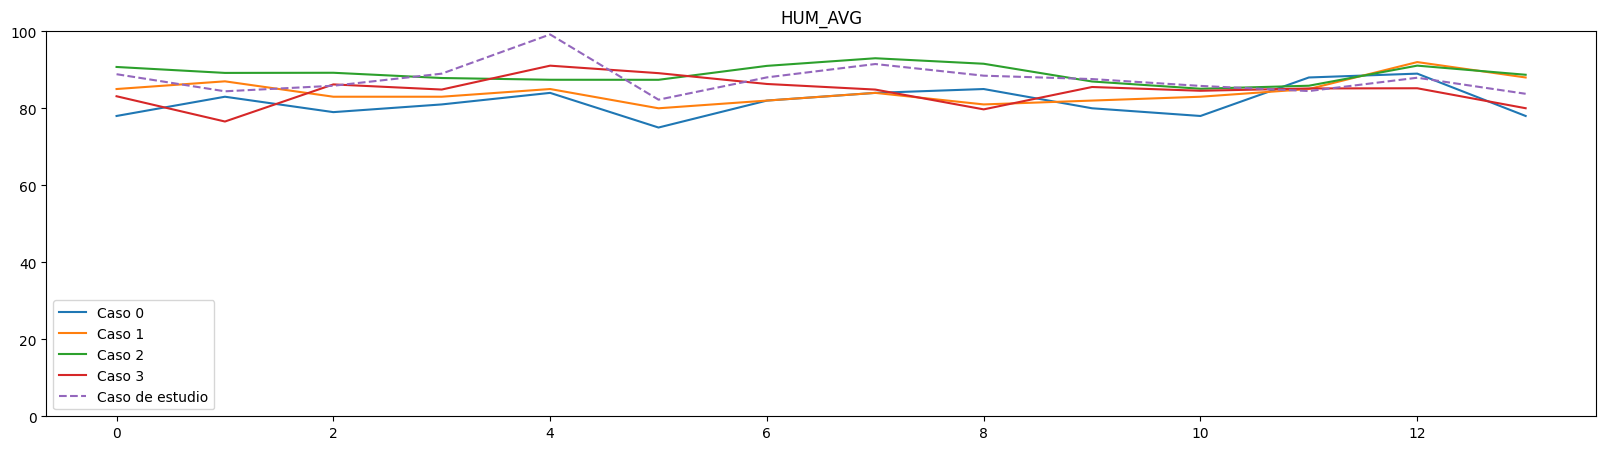

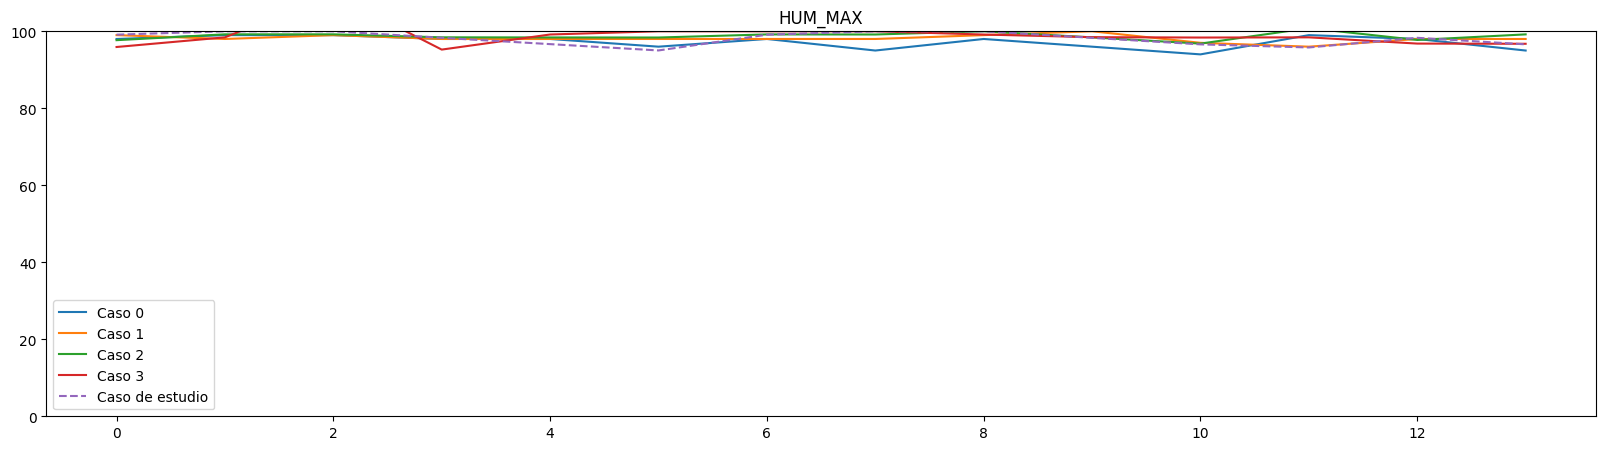

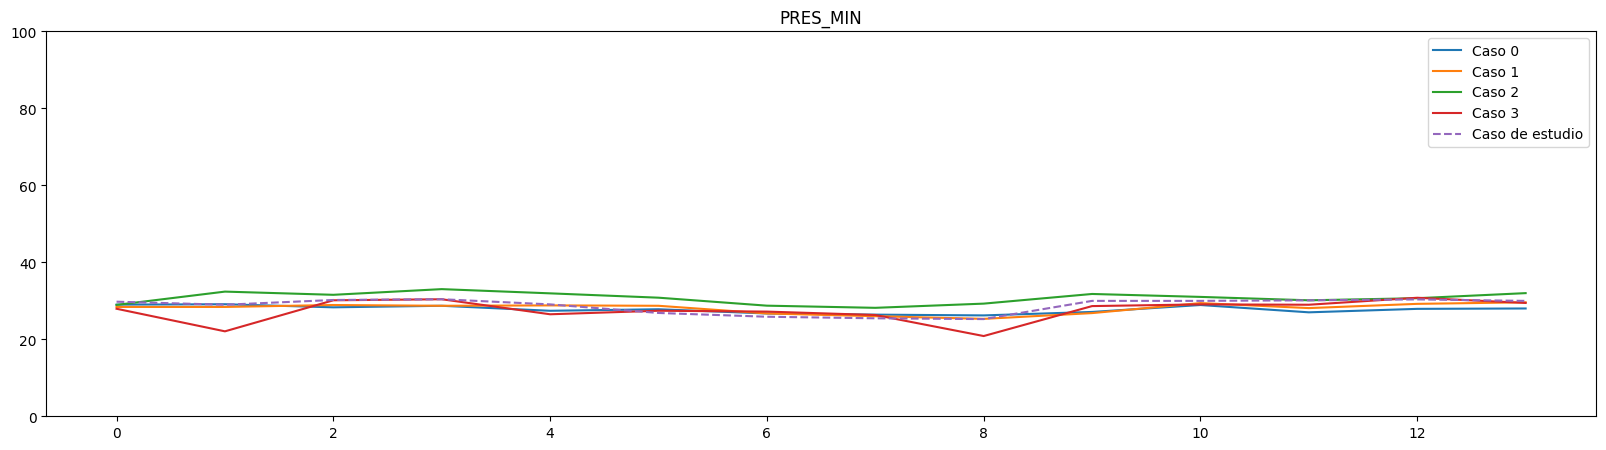

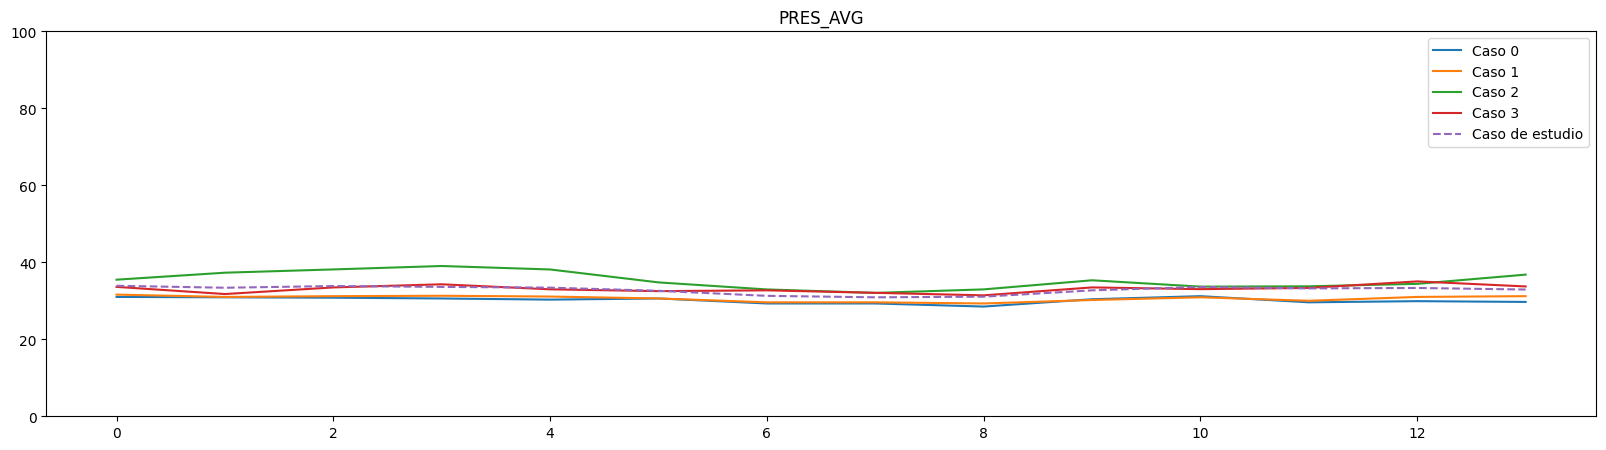

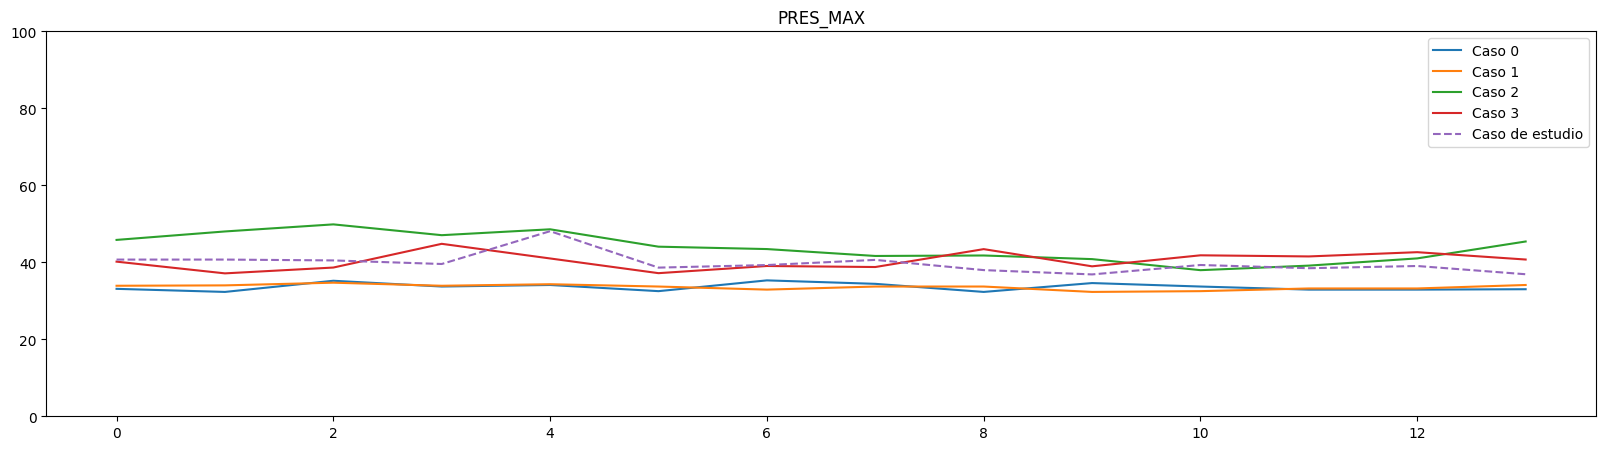

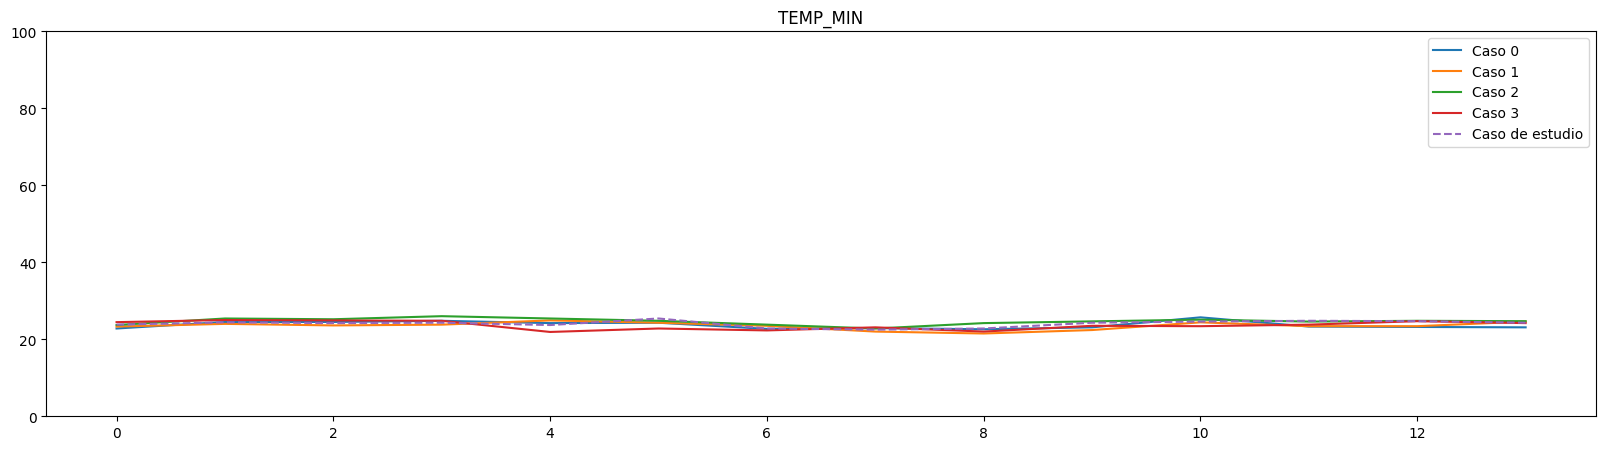

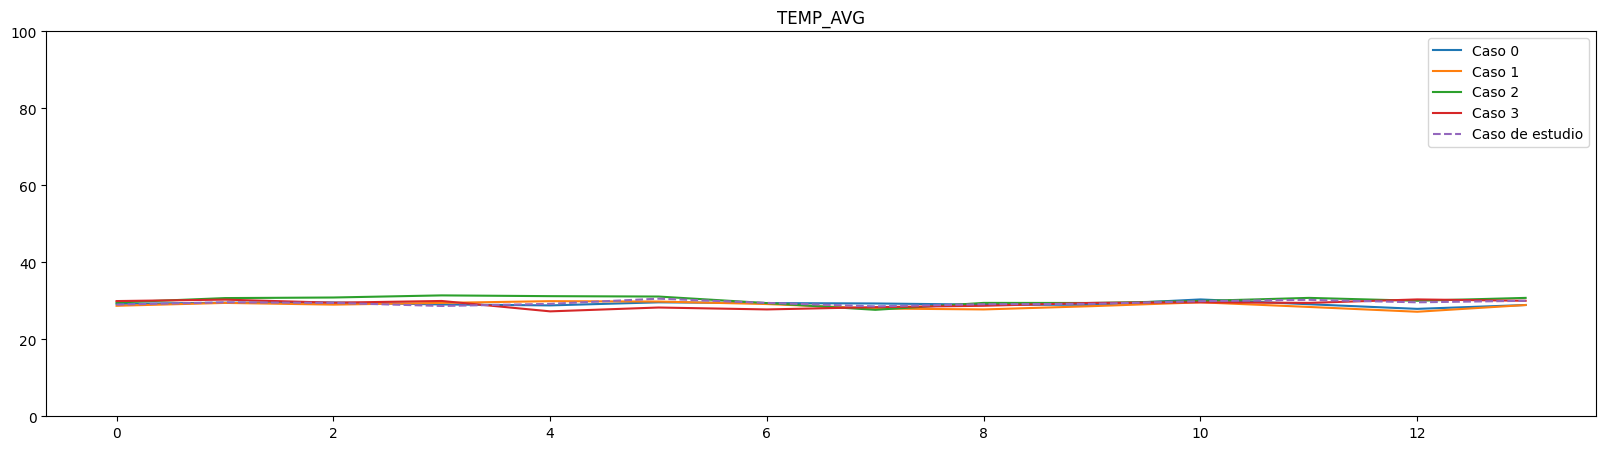

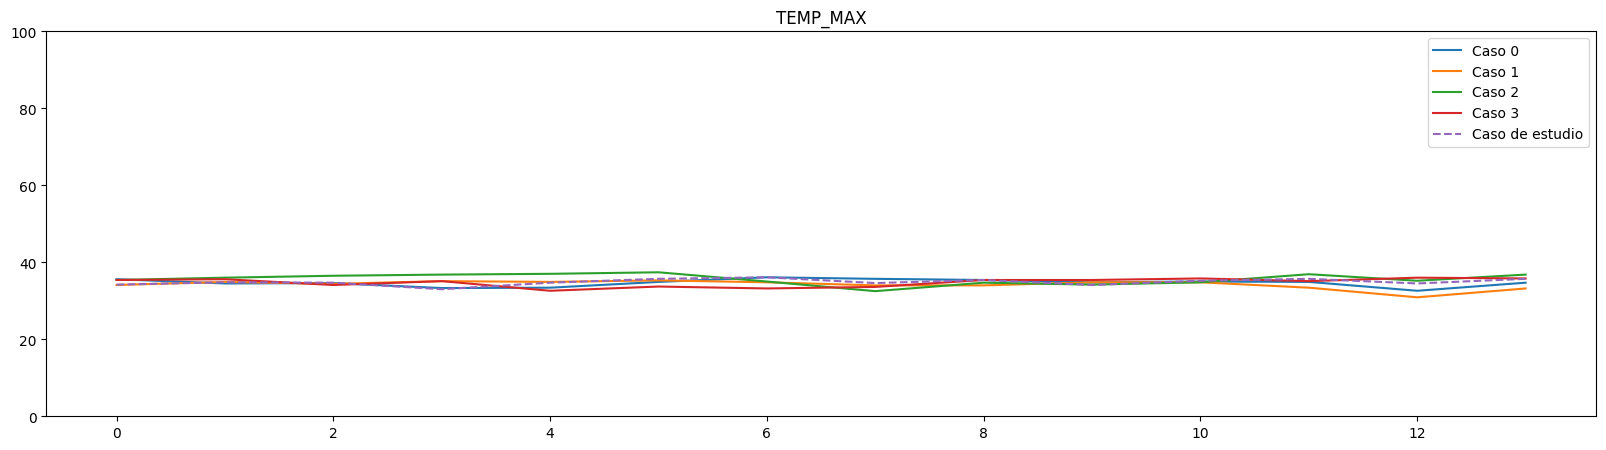

In [298]:
for n_component in range(componentsLen):
    plt.figure(figsize=(20, 5))
    plt.title(inputNames[n_component])
    plt.ylim((0, 100))
    for i, tupla in enumerate(bestSorted):
        plt.plot(windows[tupla[0]][:, n_component], label="Caso " + str(i))

    plt.plot(targetWindow[:, n_component], "--", label="Caso de estudio")
    plt.legend()


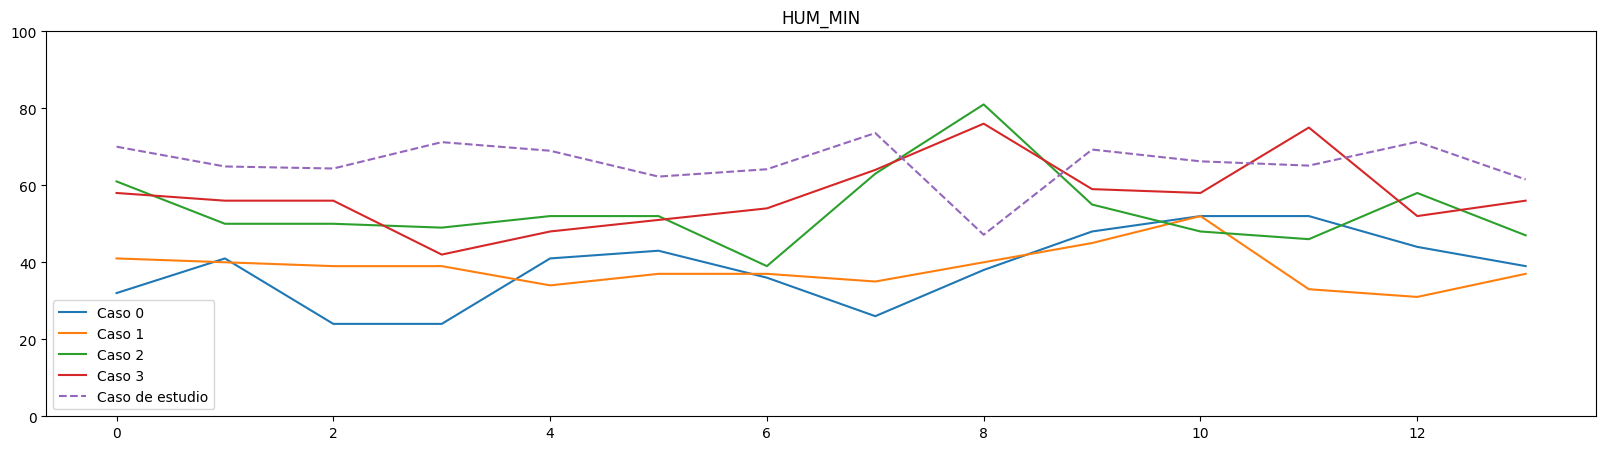

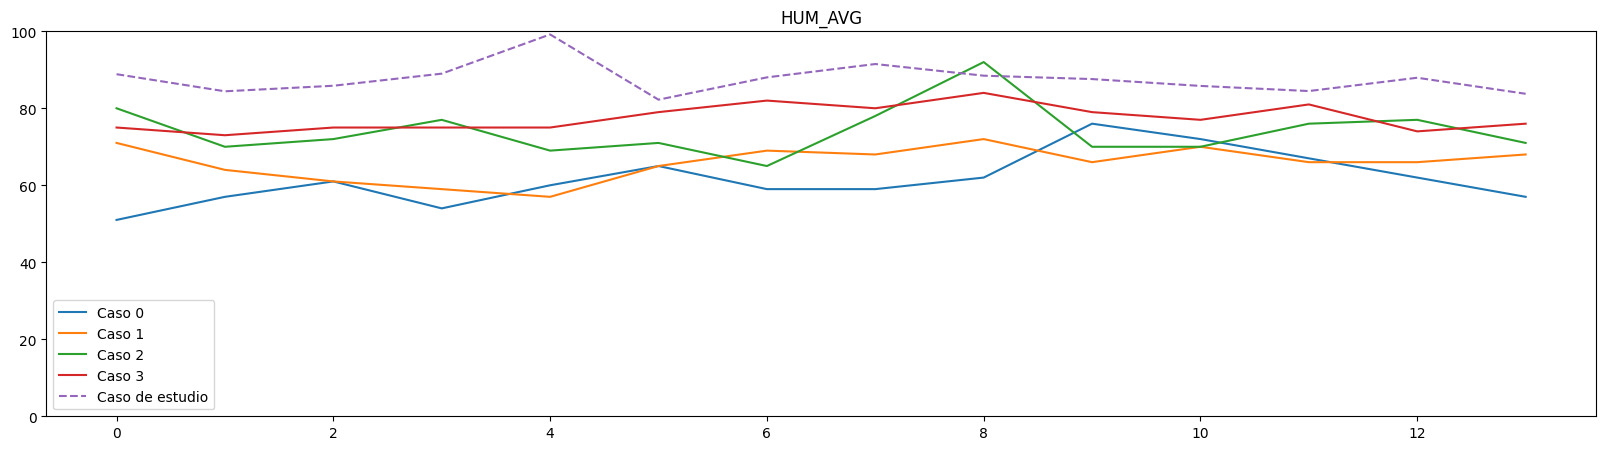

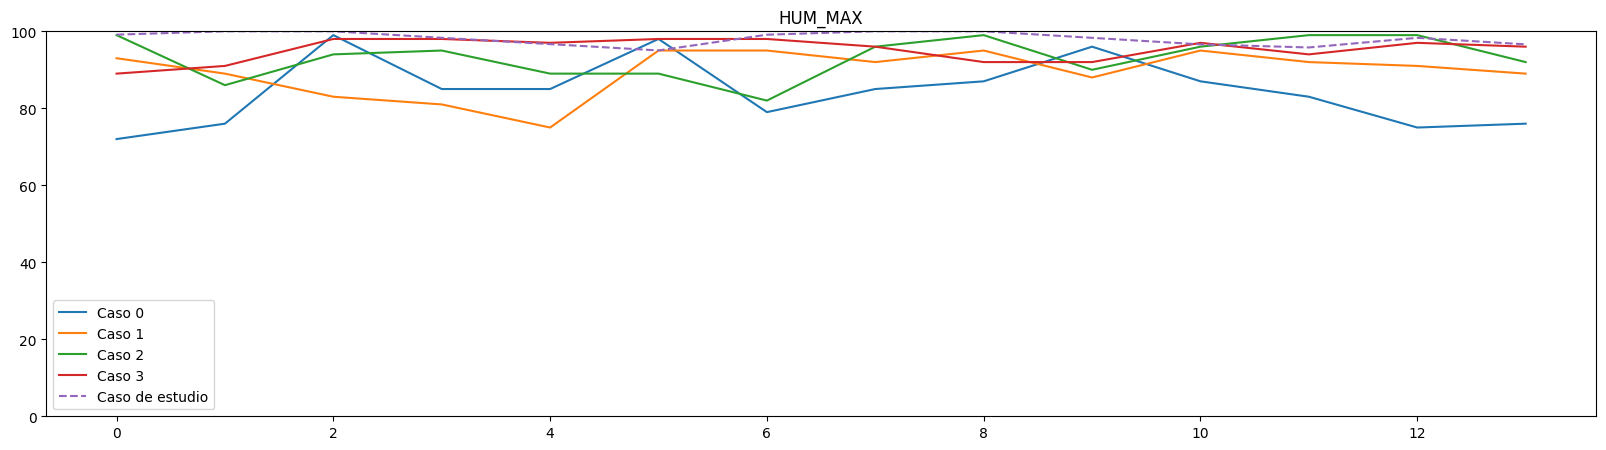

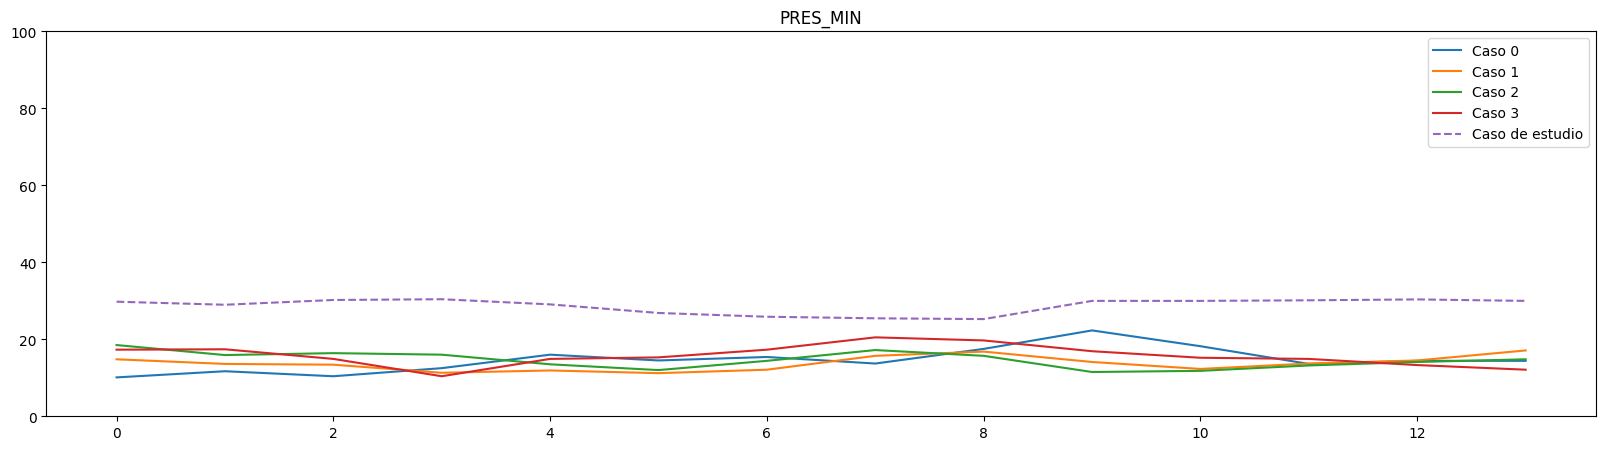

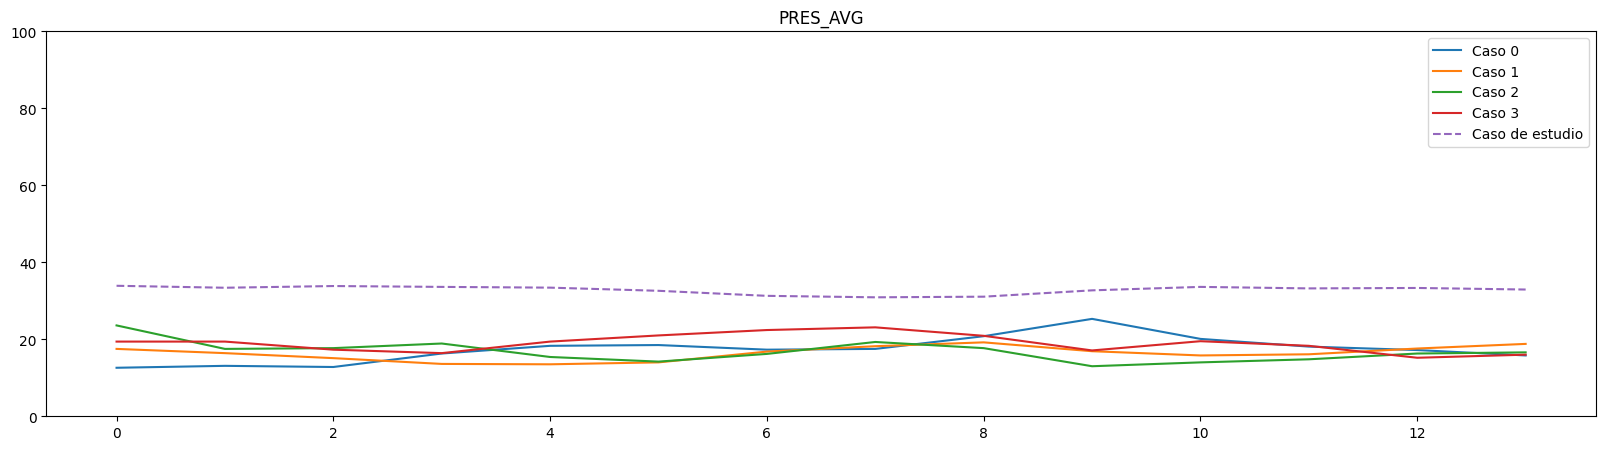

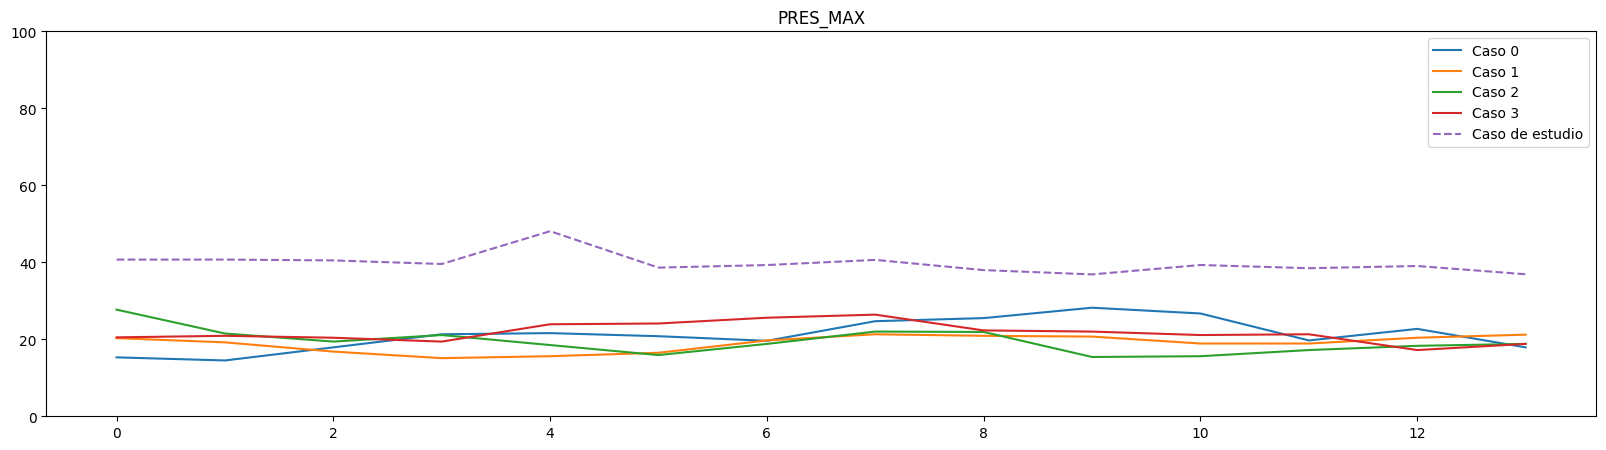

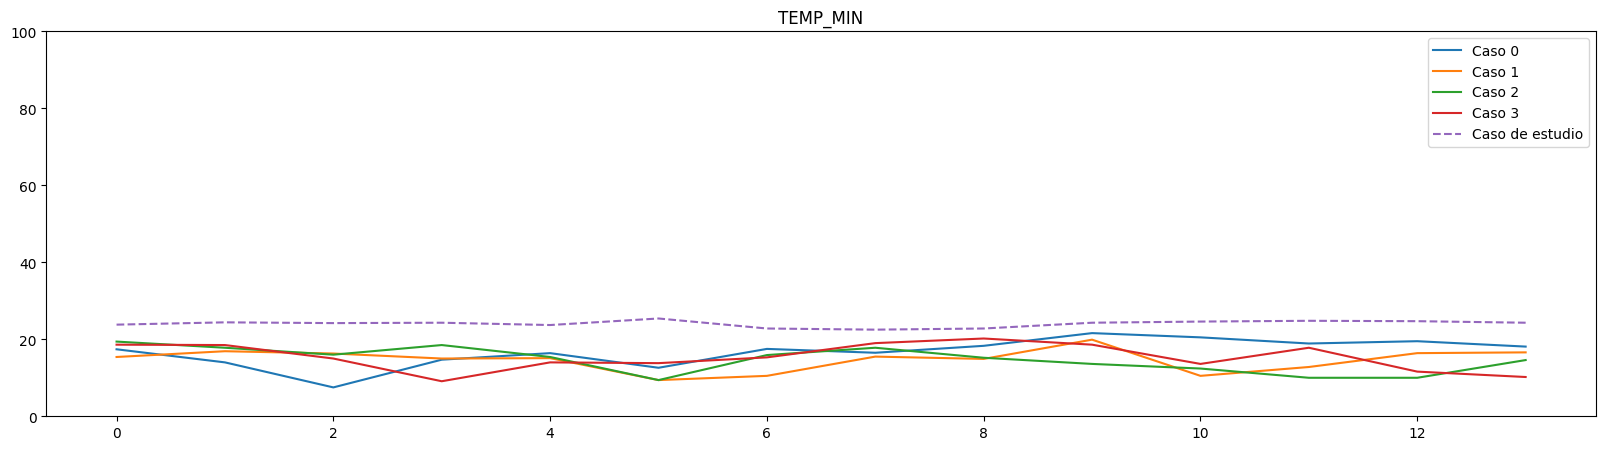

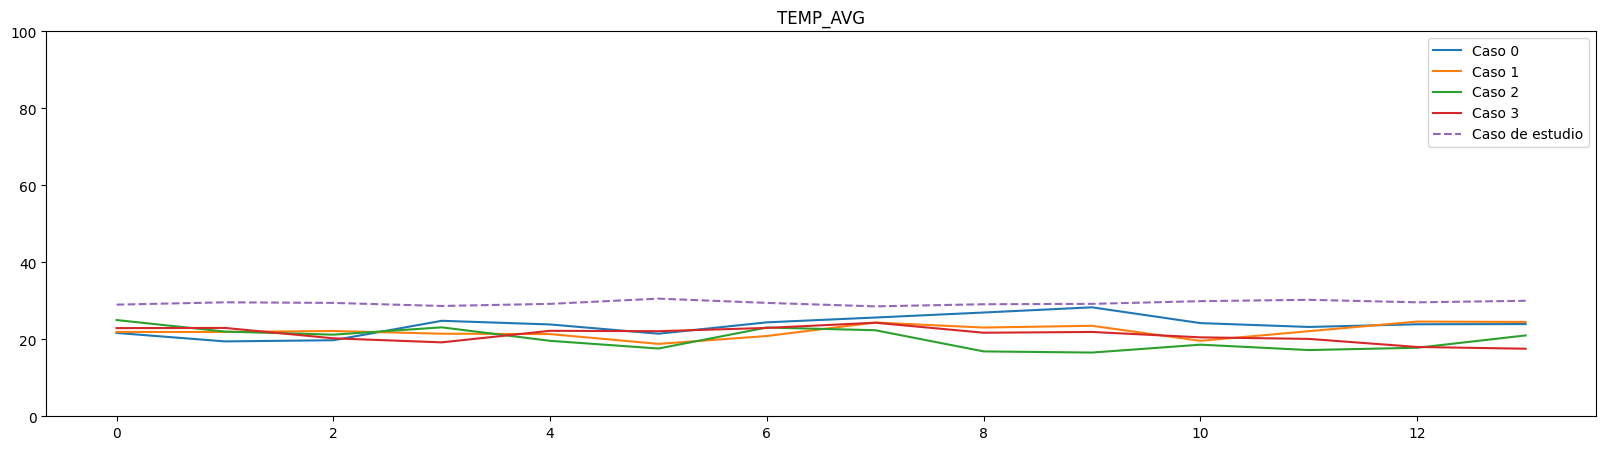

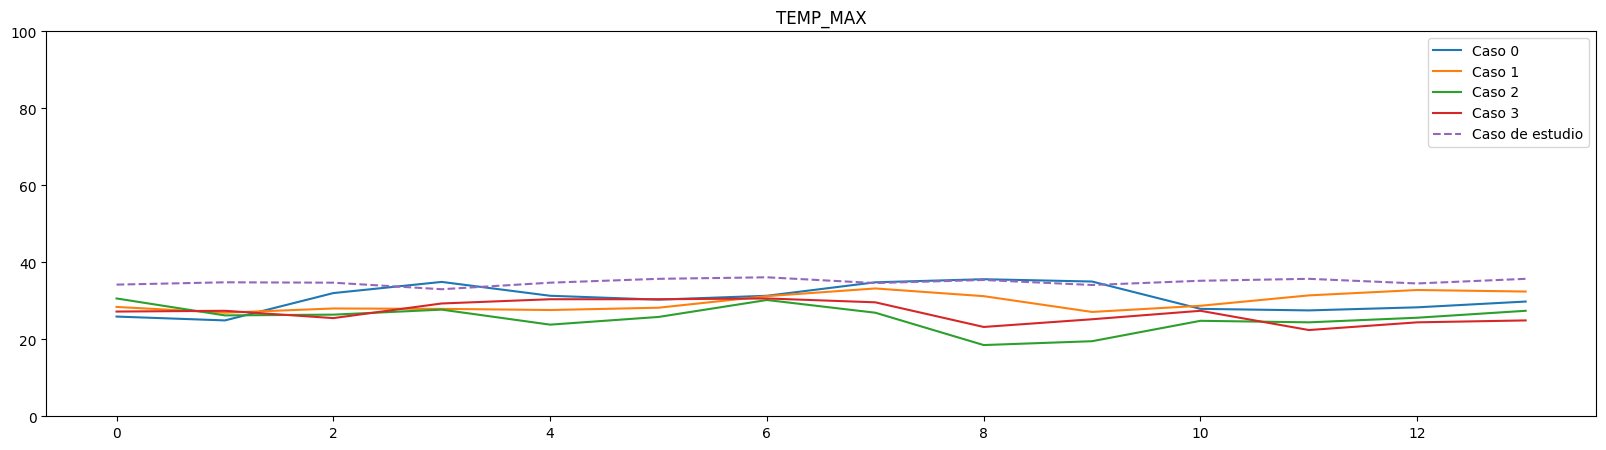

In [168]:
for n_component in range(componentsLen):
    plt.figure(figsize=(20, 5))
    plt.title(inputNames[n_component])
    plt.ylim((0, 100))
    for i, tupla in enumerate(worstSorted):
        plt.plot(windows[tupla[0]][:, n_component], label="Caso " + str(i))
    plt.plot(targetWindow[:, n_component], "--", label="Caso de estudio")
    plt.legend()

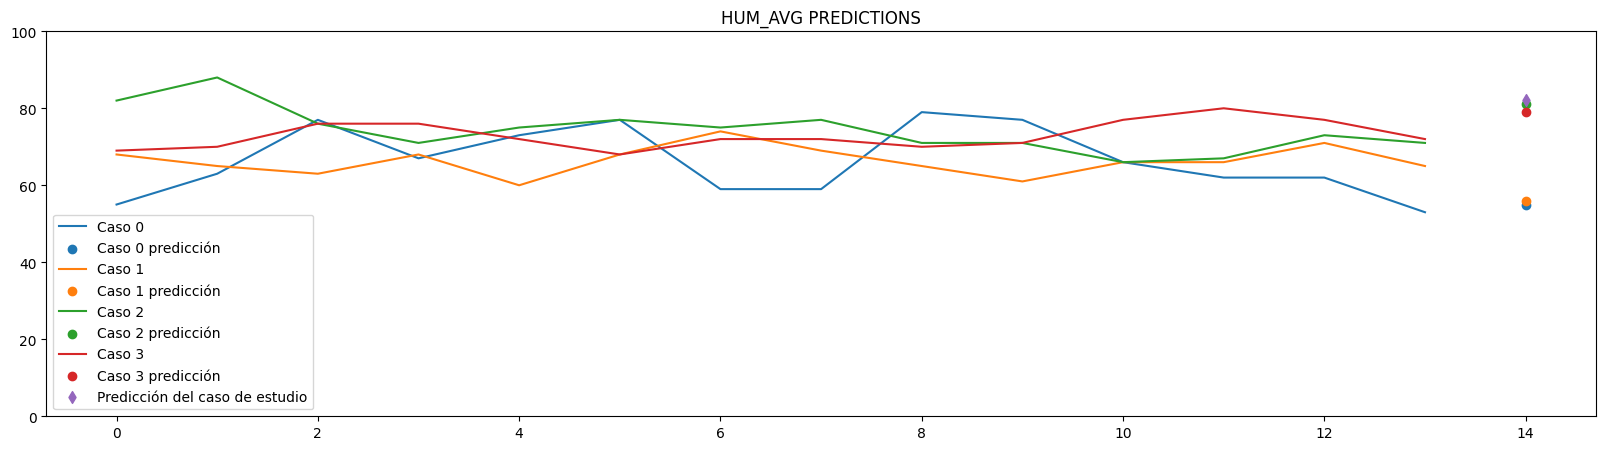

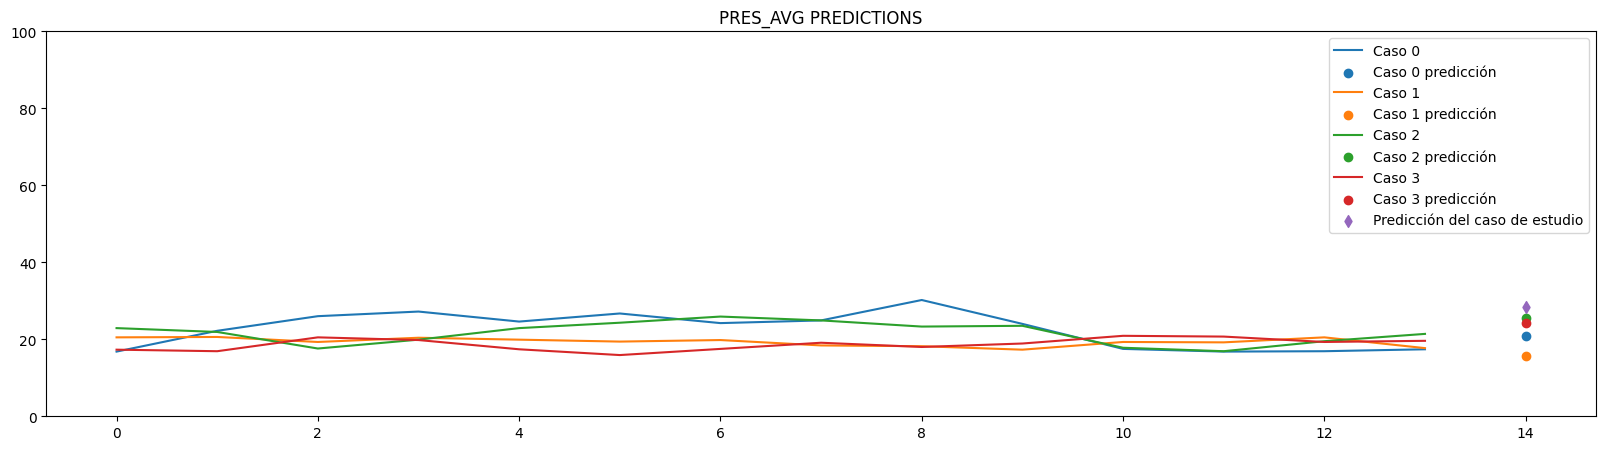

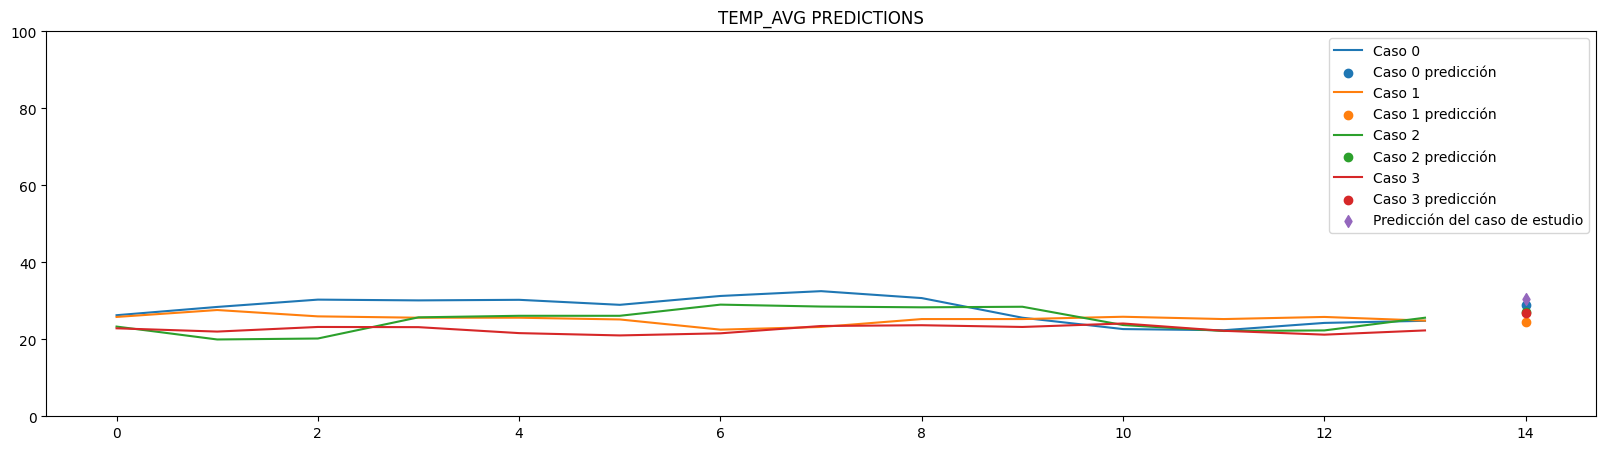

In [378]:
for n_component in range(3):
    plt.figure(figsize=(20, 5))
    plt.title(outputNames[n_component] + " PREDICTIONS")
    plt.ylim((0, 100))
    for i, tupla in enumerate(worstSorted):
        pass
        plt.plot(target[tupla[0]: tupla[0] + windowLen][:, n_component], label="Caso " + str(i))
        plt.scatter(windowLen, target[tupla[0] + windowLen + 1][n_component], label="Caso " + str(i) + " predicción")
    plt.scatter(windowLen, predictionTargetWindow[:, n_component], marker="d", label="Predicción del caso de estudio")
    plt.legend()

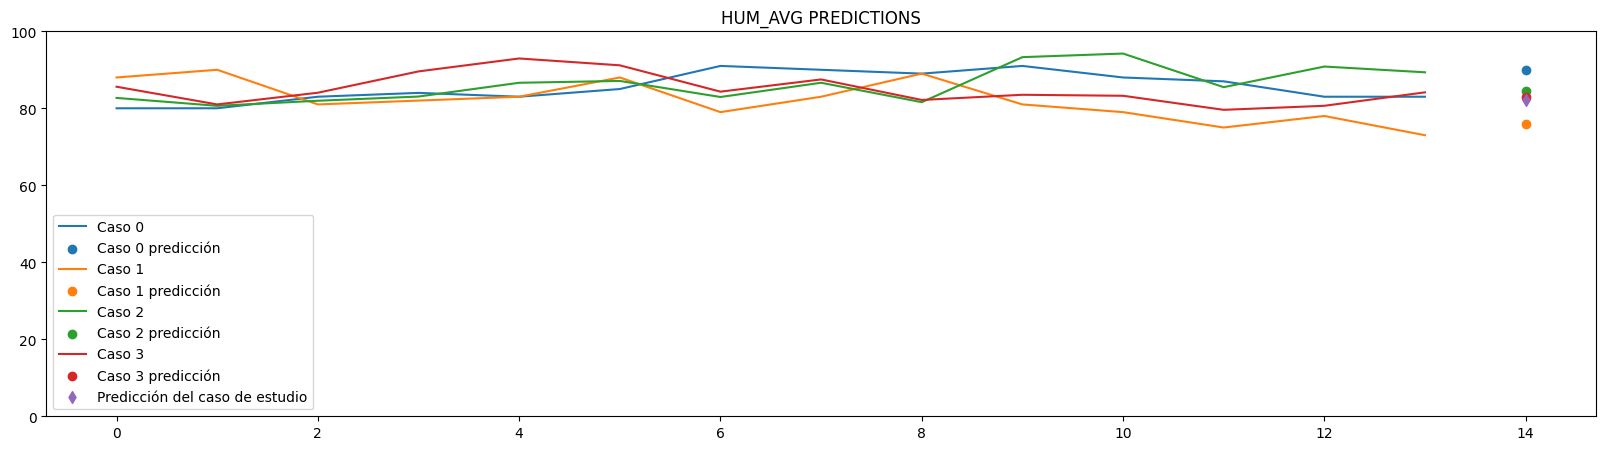

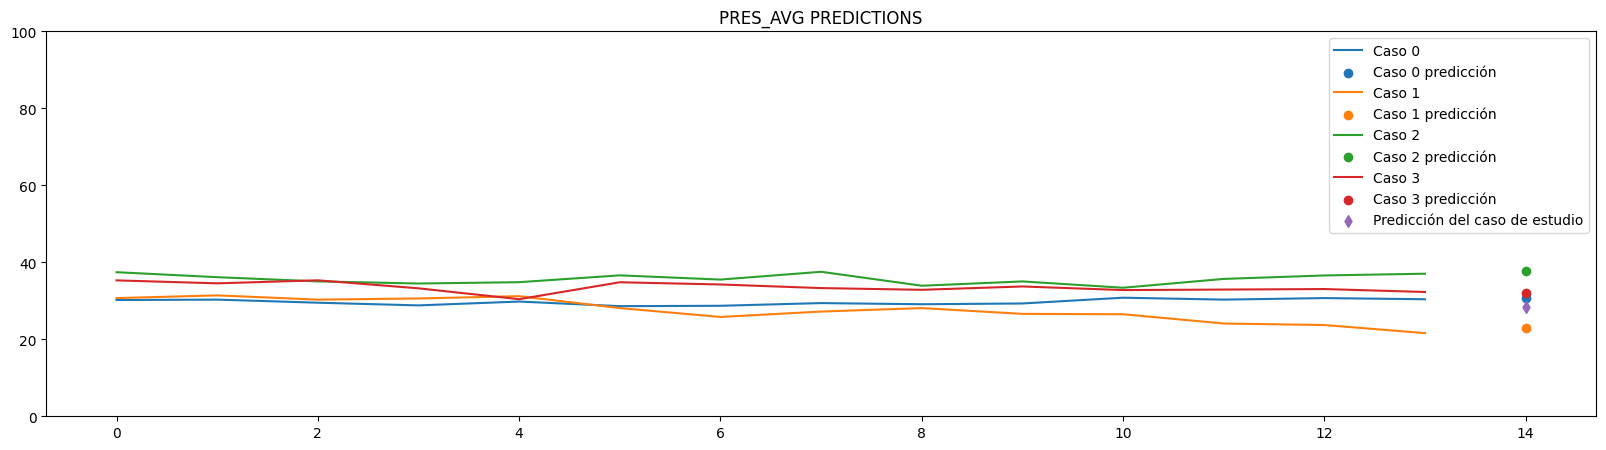

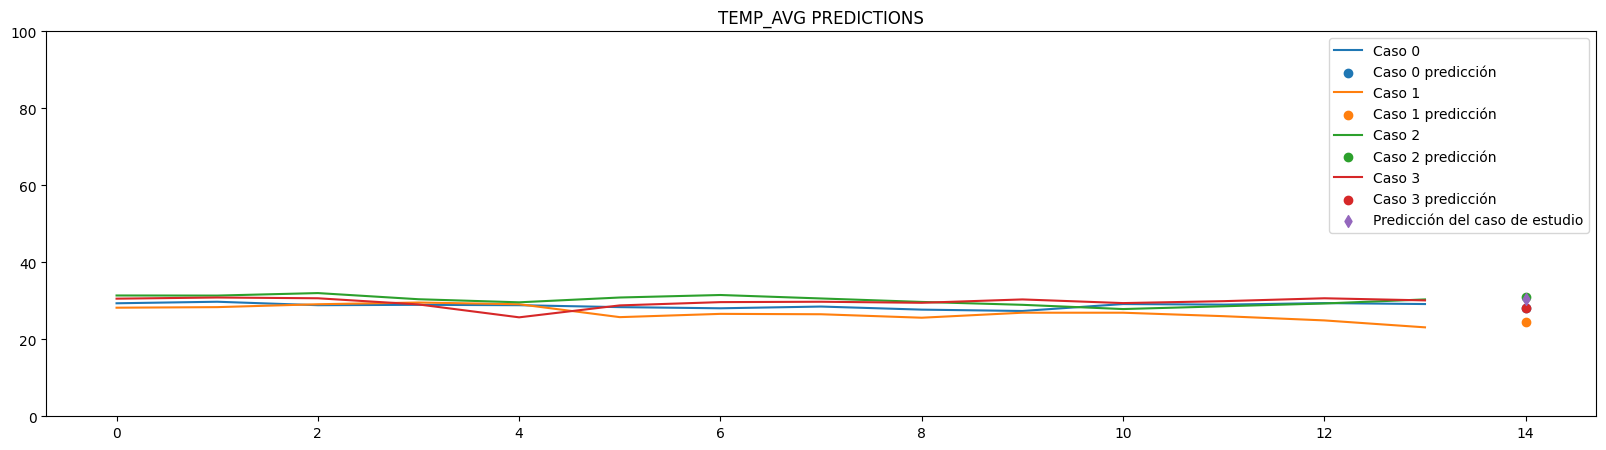

In [379]:
for n_component in range(3):
    plt.figure(figsize=(20, 5))
    plt.title(outputNames[n_component] + " PREDICTIONS")
    plt.ylim((0, 100))
    for i, tupla in enumerate(bestSorted):
        pass
        plt.plot(target[tupla[0]: tupla[0] + windowLen][:, n_component], label="Caso " + str(i))
        plt.scatter(windowLen, target[tupla[0] + windowLen + 1][n_component], label="Caso " + str(i) + " predicción")
    plt.scatter(windowLen, predictionTargetWindow[:, n_component], marker="d", label="Predicción del caso de estudio")
    plt.legend()

In [374]:
bestMAE = []
for tupla in bestSorted:
    bestMAE.append(mean_absolute_error(target[tupla[0]], predictionTargetWindow.reshape(-1, 1)))
    print(mean_absolute_error(target[tupla[0]], predictionTargetWindow.reshape(-1, 1)))

1.6931418100992832
3.5108776092529297
3.480948649259441
3.466224842592774


In [375]:
worstMAE = []
for tupla in worstSorted:
    worstMAE.append(mean_absolute_error(target[tupla[0]], predictionTargetWindow.reshape(-1, 1)))
    print(mean_absolute_error(target[tupla[0]], predictionTargetWindow.reshape(-1, 1)))

14.33174680074056
8.915080134073893
4.28174680074056
10.63174680074056


1.6931418100992832
3.5108776092529297
3.480948649259441
3.466224842592774


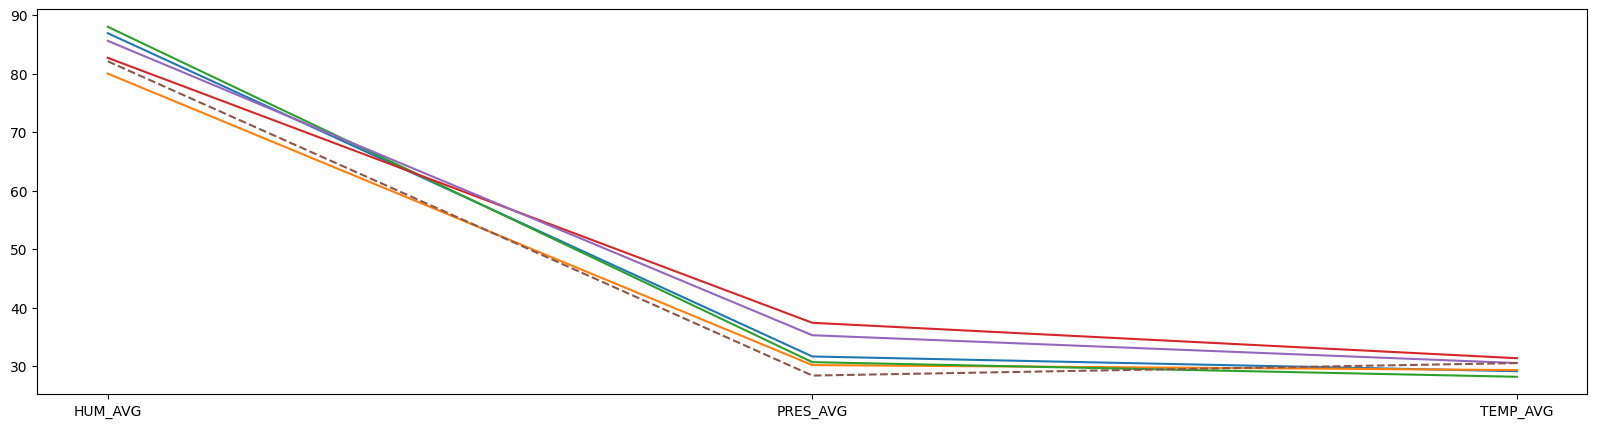

In [361]:
plt.figure(figsize=(20, 5))
plt.plot(outputNames, target[-1])
for i, tupla in enumerate(bestSorted):
    plt.plot(target[tupla[0]])
    print(mean_absolute_error(target[tupla[0]], predictionTargetWindow.reshape(-1, 1)))
plt.plot(predictionTargetWindow.reshape(-1, 1), "--", label="Resultados de predicción")

14.33174680074056
8.915080134073893
4.28174680074056
10.63174680074056


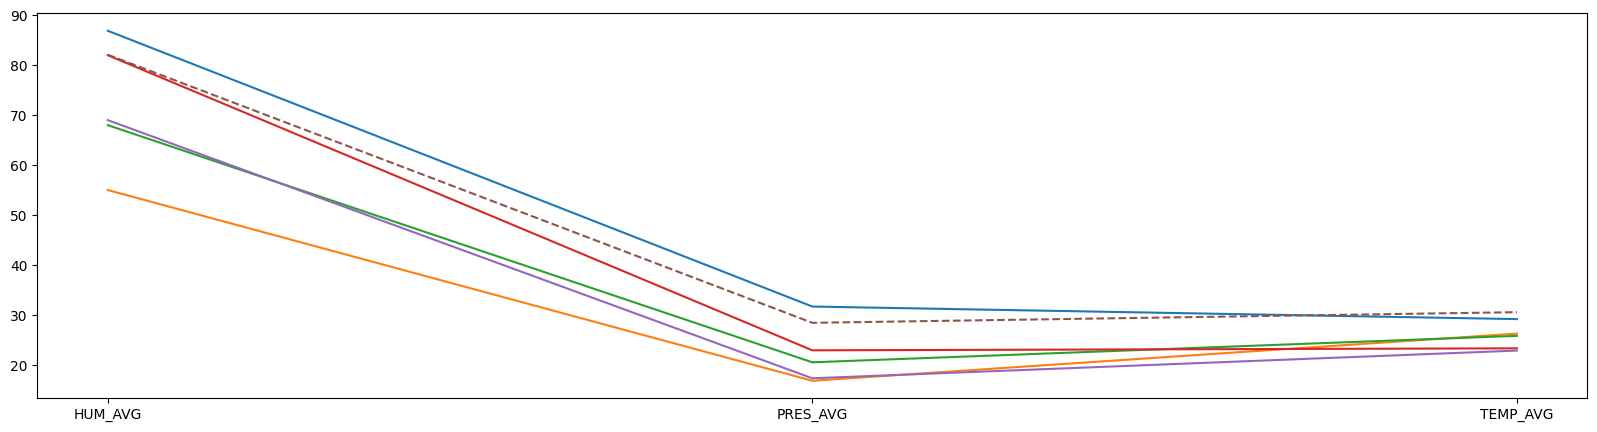

In [360]:
plt.figure(figsize=(20, 5))
plt.plot(outputNames, target[-1])
for i, tupla in enumerate(worstSorted):
    plt.plot(target[tupla[0]])
plt.plot(predictionTargetWindow.reshape(-1, 1), "--", label="Resultados de predicción")

In [376]:
d = {'index': dict(bestSorted).keys(), 'CCI': dict(bestSorted).values(), "MAE": bestMAE,
     'index.1': dict(worstSorted).keys(), 'CCI.1': dict(worstSorted).values(), "MAE.1": worstMAE}
df = pd.DataFrame(data=d)

In [377]:
df

,index,CCI,MAE,index.1,CCI.1,MAE.1
0,4972,1.000000,1.693142,4809,0.410155,14.331747
1,263,0.979834,3.510878,1841,0.423713,8.915080
2,6062,0.975253,3.480949,3653,0.437751,4.281747
3,6410,0.967463,3.466225,1101,0.440702,10.631747


In [380]:
print("ww", end="\r")
print("aa", end="\r")